# Brainstation Capstone: Airline Delays - ML Modeling

James Church

08/2023

-----

<a name=top></a>
## [Pre-Modelling Setup:](#0)
- [Models Used.](#0a)
</br>

- [Environment Setup.](#0b)
</br>

- [Loading and Preping the Data for Modeling.](#0c)
</br>

- [Transforming the Columns into insertable features.](#0d)
</br>

- [Making Train-Test split.](#0e)
</br>

- [Scaling the Data & Label Encoding Target Data.](#0f)
</br>

## [Part 1 - Logistic Regression:](#1)
- [Testing Base Accuracy.](#1a)
</br>

- [Cross validation and Different Solver Types.](#1b)
</br>

- [Cross Validation for Hyperparameter Tuning.](#1c)
</br>

- [Final Log-Reg Model Test Score Accuracy and Visualization](#1d)
</br>

## [Part 2 - Decision Tree:](#2)
- [Base Modelling.](#2a)
</br>

- [Hyperparamter Testing.](#2b)
</br>

- [PCA Analysis of Variance.](#2c)
</br>

- [Hyperparamerterized Model on Test Set.](#2d)
</br>

### -[Scoring Update](#score)-

## [Part 3 - Random Forest:](#3)
- [Base Model - Looking into 'Long Delay' Recall.](#3a)
</br>

- [Random Forest Hyperparameter Tuning.](#3b)
</br>

- [Adjusting Decision Tree Class Thresholds.](#3c)
</br>

- [Random Forest Test Set Performance.](#3d)
</br>

## [Part 4 - SVM:](#4)
- [Define Functions for SVM Setup.](#4a)
</br>

- [Testing SVM with Various Data Sizes and Parameters.](#4b)
</br>

- [SVM Hyperparameter Tuning on Sub-Sampled Data.](#4c)
</br>

- [SVM Hyperparameter Summary.](#4d)
</br>

- [SVM Test Data Accuracy.](#4e)

## [Part 5 - XGBoost:](#5)
- [Baseline XGBoost Modelling.](#5a)
</br>

- [XGBoost Hyperparameter Testing.](#5b)
</br>

- [XGBoost Test Set Accuracy.](#5c)

## [Modeling Analysis:](#6)

## [Conclusion and Future Modeling Direction](#7)

-----

<a name=0></a>
# Part 0 - Pre-Modelling Setup

<a name=0a></a>
## Models Used

The flight delay modelling is a three-class multiclass problem. All the models below were selected because of their varied ability to deal with multiclass problems.

*As we go through the models, we will be applying some additional scoring analysis, feature visualization, and hyperparameter tuning methods, such as PCA and thresholding. While many of these additional steps can be applied to every model, this is meant to show the buildup of testing and validation procedures along the modelling process. A story line of a building complexity within modelling, so to speak.*

### Logistic Regression: 
Logistic regression is a linear model commonly used for binary classification but can also be extended to multi-class classification using techniques like one-vs-rest or softmax regression.

### Decision Trees: 
Decision trees recursively split the data based on features to make predictions. They are easy to understand and interpret but can be prone to overfitting.

### Random Forest: 
Random forest is an ensemble model that combines multiple decision trees. It improves performance by reducing overfitting and capturing more complex relationships in the data.

### Support Vector Machines (SVM): 
SVMs find a hyperplane that maximally separates the classes. They can handle non-linear decision boundaries using kernel functions.

### Gradient Boosting - XGBoost: 
Gradient boosting algorithms, such as XGBoost or LightGBM, sequentially train weak learners and combine their predictions. They can handle complex interactions and perform well in various domains.

<a name=0b></a>
## Environment Setup

Before we do any modelling, we need to make sure some libraries are installed on the system and imported for use.

In [2]:
## Scale the notebook to fit the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# conda install python-graphviz
# !pip install pydotplus
# !pip install xgboost
# !pip install xgboost

In [69]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data serialization and deserialization
import pickle
import joblib

# Graph visualization
import graphviz
import pydotplus
from IPython.display import SVG

# Statistical functions
from scipy import stats

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate, HalvingGridSearchCV, cross_val_predict

# Data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import plot_importance

# Graph visualization using Graphviz
from graphviz import Source

<a name=0c></a>
## Loading and Preping the Data for Modeling

In [4]:
# Load the DataFrame from the file
with open('flight_df.pickle', 'rb') as file:
    flight_df = pickle.load(file)

In [5]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308253 entries, 5680782 to 3397334
Data columns (total 29 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   MONTH                                     308253 non-null  int64  
 1   DAY_OF_WEEK                               308253 non-null  int64  
 2   DEP_DELAY_NEW                             308253 non-null  float64
 3   DEP_TIME_BLK                              308253 non-null  object 
 4   DISTANCE                                  308253 non-null  float64
 5   SEGMENT_NUMBER                            308253 non-null  int64  
 6   CONCURRENT_FLIGHTS                        308253 non-null  int64  
 7   NUMBER_OF_SEATS                           308253 non-null  int64  
 8   CARRIER_NAME                              308253 non-null  object 
 9   AIRPORT_FLIGHTS_MONTH                     308253 non-null  int64  
 10  AIRLINE_FLIGH

In [6]:
category_counts = flight_df['Delay Category'].value_counts()
category_counts

No Delay       102751
Minor Delay    102751
Long Delay     102751
Name: Delay Category, dtype: int64

<a name=0d></a>
## Transforming the Columns into insertable features

In [7]:
# Select object columns
object_columns = flight_df.select_dtypes(include='object').columns

# Display info for object columns only
flight_df[object_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308253 entries, 5680782 to 3397334
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DEP_TIME_BLK       308253 non-null  object
 1   CARRIER_NAME       308253 non-null  object
 2   DEPARTING_AIRPORT  308253 non-null  object
 3   PREVIOUS_AIRPORT   308253 non-null  object
 4   Delay Category     308253 non-null  object
dtypes: object(5)
memory usage: 14.1+ MB


In [8]:
# Select the columns to be one-hot encoded
columns_to_encode = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', ]

In [9]:
# Perform one-hot encoding using pandas get_dummies function
df_encoded = pd.get_dummies(flight_df, columns=columns_to_encode)

In [10]:
df_encoded

DEP_DELAY_NEW  DISTANCE  SEGMENT_NUMBER  CONCURRENT_FLIGHTS  \
5680782            0.0     689.0               3                  50   
6376220            0.0    1846.0               1                  66   
6229419            0.0     214.0               2                  55   
6164851            0.0     691.0               6                  70   
3300280            0.0    1199.0               3                  74   
...                ...       ...             ...                 ...   
6325773           90.0     113.0               1                  33   
1908682          163.0     689.0               2                  63   
3292967           73.0     760.0               2                  84   
2107710           35.0     175.0               6                  71   
3397334           72.0     612.0               3                  59   

         NUMBER_OF_SEATS  AIRPORT_FLIGHTS_MONTH  AIRLINE_FLIGHTS_MONTH  \
5680782              157                  31151                  79989   
6376220              160                  27188                  79228   
6229419              180                  32251                  81498   
6164851               79                  25322                  18545   
3300280               76                  35086                  26909   
...                  ...                    ...                    ...   
6325773               44                  25322                  26721   
1908682              158                  32678                  81803   
3292967              199                  35086                  90457   
2107710              140                  25360                  78894   
3397334              124                  29376                  55374   

         AIRLINE_AIRPORT_FLIGHTS_MONTH  AVG_MONTHLY_PASS_AIRPORT  \
5680782                          19506                   4365661   
6376220                           5350                   3103410   
6229419                          19689                   4365661   
6164851                           3234                   2907365   
3300280                            544                   4365661   
...                                ...                       ...   
6325773                           5416                   2907365   
1908682                          20473                   4365661   
3292967                          21769                   4365661   
2107710                          12702                   2907365   
3397334                           6976                   3103410   

         AVG_MONTHLY_PASS_AIRLINE  ...  PREVIOUS_AIRPORT_Westchester County  \
5680782                  12460183  ...                                    0   
6376220                  11744595  ...                                    0   
6229419                  12460183  ...                                    0   
6164851                   1191889  ...                                    0   
3300280                   1529740  ...                                    0   
...                           ...  ...                                  ...   
6325773                   1204766  ...                                    0   
1908682                  12460183  ...                                    0   
3292967                  12460183  ...                                    0   
2107710                  11744595  ...                                    0   
3397334                   8501631  ...                                    0   

         PREVIOUS_AIRPORT_Wichita Mid-Continent  \
5680782                                       0   
6376220                                       0   
6229419                                       0   
6164851                                       0   
3300280                                       0   
...                                         ...   
6325773                                       0   
1908682                                       0   
3292967                       

In [11]:
# Select object columns from the encoded DataFrame
object_columns = df_encoded.select_dtypes(include='object').columns

# Display info for object columns only
df_encoded[object_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308253 entries, 5680782 to 3397334
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Delay Category  308253 non-null  object
dtypes: object(1)
memory usage: 4.7+ MB


In [12]:
# Separate the target variable (y) and the feature matrix (X)
X = df_encoded.drop(['Delay Category', 'DEP_DELAY_NEW'], axis=1)
y = df_encoded['Delay Category']

*We drop 'DEP_DELAY_NEW' here because it's the numeric / continuous version of our categorical variable 'Delay Category'.*

In [13]:
# Display the feature matrix (X) and target variable (y)
print("Feature Matrix (X):")
X.head()

Feature Matrix (X):


DISTANCE  SEGMENT_NUMBER  CONCURRENT_FLIGHTS  NUMBER_OF_SEATS  \
5680782     689.0               3                  50              157   
6376220    1846.0               1                  66              160   
6229419     214.0               2                  55              180   
6164851     691.0               6                  70               79   
3300280    1199.0               3                  74               76   

         AIRPORT_FLIGHTS_MONTH  AIRLINE_FLIGHTS_MONTH  \
5680782                  31151                  79989   
6376220                  27188                  79228   
6229419                  32251                  81498   
6164851                  25322                  18545   
3300280                  35086                  26909   

         AIRLINE_AIRPORT_FLIGHTS_MONTH  AVG_MONTHLY_PASS_AIRPORT  \
5680782                          19506                   4365661   
6376220                           5350                   3103410   
6229419                          19689                   4365661   
6164851                           3234                   2907365   
3300280                            544                   4365661   

         AVG_MONTHLY_PASS_AIRLINE  FLT_ATTENDANTS_PER_PASS  ...  \
5680782                  12460183                 0.000144  ...   
6376220                  11744595                 0.000098  ...   
6229419                  12460183                 0.000144  ...   
6164851                   1191889                 0.000000  ...   
3300280                   1529740                 0.000001  ...   

         PREVIOUS_AIRPORT_Westchester County  \
5680782                                    0   
6376220                                    0   
6229419                                    0   
6164851                                    0   
3300280                                    0   

         PREVIOUS_AIRPORT_Wichita Mid-Continent  \
5680782                                       0   
6376220                                       0   
6229419                                       0   
6164851                                       0   
3300280                                       0   

         PREVIOUS_AIRPORT_Wilkes Barre Scranton International  \
5680782                                                  0      
6376220                                                  0      
6229419                                                  0      
6164851                                                  0      
3300280                                                  0      

         PREVIOUS_AIRPORT_Will Rogers World  \
5680782                                   0   
6376220                                   0   
6229419                                   0   
6164851                                   0   
3300280                                   0   

         PREVIOUS_AIRPORT_William B. Heilig Field  \
5680782                                         0   
6376220                                         0   
6229419                                         0   
6164851                                         0   
3300280                                         0   

         PREVIOUS_AIRPORT_William P Hobby  \
5680782                                 0   
6376220                                 0   
6229419                                 0   
6164851                                 0   
3300280                                 0   

         PREVIOUS_AIRPORT_Wilmington International  \
5680782                                          0   
6376220                                          0   
6229419                                          0   
6164851                                          0   
3300280                                          0   

         PREVIOUS_AIRPORT_Yampa Valley  PREVIOUS_AIRPORT_Yellowstone Regional  \
5680782                              0                                      0   
6376220                              0                        

In [14]:
print("\nTarget Variable (y):")
y.head()


Target Variable (y):


5680782    No Delay
6376220    No Delay
6229419    No Delay
6164851    No Delay
3300280    No Delay
Name: Delay Category, dtype: object

We now have our full feature encoded dataframe, X. Split from the y target values.

<a name=0e></a>
## Making Train-Test split

In [15]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

We will be using this split across our different models to keep the testing consistent, avoiding varying distributions and randomness from doing additional random splitting across different models.

<a name=0f></a>
## Scaling the Data & Label Encoding Target Data

As many of our models require data to be scaled for optimiation in calculation speed and feature weight, we will use a standard scaler. We also need to lablel encode, as some models can't take string target values as input and output results.

In [16]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Scale the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Create a label encoder object
label_encoder = LabelEncoder()

# Fit the encoder on the training labels
label_encoder.fit(y_train)

# Transform the training and testing labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [18]:
# Get the class names associated with the encoded class numbers
class_names = label_encoder.classes_

# Print the class names associated with their respective class numbers
for encoded_class, class_name in enumerate(class_names):
    print(f"Class Number {encoded_class}: Class Name '{class_name}'")

Class Number 0: Class Name 'Long Delay'
Class Number 1: Class Name 'Minor Delay'
Class Number 2: Class Name 'No Delay'


----

[Index](#top)

----

<a name=1></a>
# Logistic Regression

<a name=1a></a>
## Testing Base Accuracy

In [14]:
# Initialize the logistic regression model
logreg = LogisticRegression(multi_class='multinomial', max_iter=1000)

# Train the model
logreg.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.4658480803231091


46.58% is our base accuracy, lets see how we can change it tuning hyperparamters.

<a name=1b></a>
## Cross validation and Different Solver Types:

In [45]:
# Initialize the logistic regression model
logreg = LogisticRegression()

# Define the parameter grid for grid search
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Initialize the grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

# Perform grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best parameters and best score from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Display the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best Parameters: {'solver': 'saga'}
Best Score: 0.4658924007157507


C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'solver': 'saga'}

Best Score: 0.4658924007157507

Here we found the best 'solver' is 'saga' with an accuracy is 46.59%

<a name=1c></a>
### Cross Validation for Hyperparameter Tuning

C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.4658072426471186


C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.4659207860260587


C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.46589240063353116


C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.4658964557013522


C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.4658924007157507


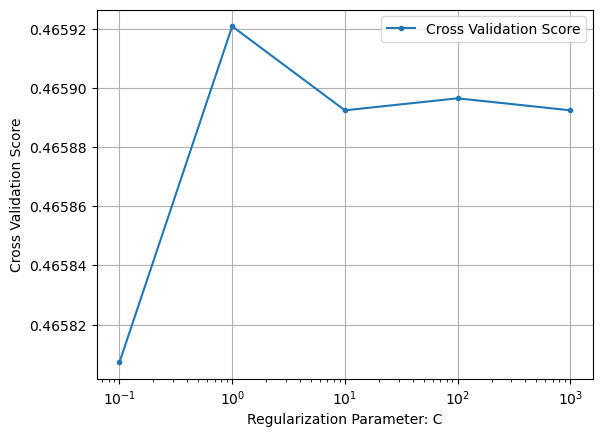

In [20]:
#Store the results
cross_validation_scores = []

C_range = np.array([.1, 1,10,100,1000])

#Do some cross validation
for c in C_range:
    LR_model = LogisticRegression(penalty='l1', C=c, solver='saga')
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(LR_model, X_train_scaled, y_train, cv = 5))
    
    # pring average cross-validation accuracy for each iteration of C
    print(cv_score)
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

Looking at the graph, we can see that a C = 1 resulted in the highest accuracy of 46.592%

<a name=1d></a>
## Final Log-Reg Model Test Score Accuracy

Now lets add these hyperparamteres to our final log reg model and test for score accuracy.

In [33]:
# Initialize the logistic regression model
logreg = LogisticRegression(penalty='l1', C=1, solver='saga', max_iter=1000)

# Train the model
logreg.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test_scaled)

# Display the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.4658480803231091


C:\Users\three\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Our final hyperparametrized model has an accuracy of 46.58%, the exact same as the base model! This means that additional hyperparameters weren't able to add any additional insight or linear patterns compared to the base model.

Let's take a look at how the weight of each feature affects the prediction classification of our 3 classes below.

In [34]:
# Get the class names
class_names = logreg.classes_

# Get the coefficients and feature names
coefficients = logreg.coef_
feature_names = X.columns

# Create a DataFrame to store the results
result_df = pd.DataFrame(columns=['Class', 'Feature', 'Coefficient'])

# Populate the DataFrame with the class names, top features, and coefficients
for class_idx, class_coef in enumerate(coefficients):
    top_features = sorted(zip(class_coef, feature_names), reverse=True)[:10]
    df = pd.DataFrame({'Class': class_names[class_idx], 'Feature': [feature for _, feature in top_features], 'Coefficient': [coef for coef, _ in top_features]})
    result_df = pd.concat([result_df, df], ignore_index=True)

# Print the result DataFrame
print("Top Features for Each Class:")
result_df

Top Features for Each Class:


Class                                    Feature  Coefficient
0    Long Delay   PRECIPITATION_DEPARTING_AIRPORT_RELATIVE     0.112269
1    Long Delay                                    MONTH_6     0.102016
2    Long Delay                      AIRLINE_FLIGHTS_MONTH     0.091405
3    Long Delay                                    MONTH_7     0.088506
4    Long Delay                                       PRCP     0.087310
5    Long Delay                                       SNOW     0.079986
6    Long Delay                      PREVIOUS_AIRPORT_NONE     0.077929
7    Long Delay                     DEP_TIME_BLK_2000-2059     0.069909
8    Long Delay                     DEP_TIME_BLK_1900-1959     0.068564
9    Long Delay                     DEP_TIME_BLK_1800-1859     0.065579
10  Minor Delay                            NUMBER_OF_SEATS     0.117838
11  Minor Delay        CARRIER_NAME_Southwest Airlines Co.     0.077127
12  Minor Delay                                   DISTANCE     0.052136
13  Minor Delay                         CONCURRENT_FLIGHTS     0.045364
14  Minor Delay                   AVG_MONTHLY_PASS_AIRLINE     0.039071
15  Minor Delay              AIRLINE_AIRPORT_FLIGHTS_MONTH     0.038285
16  Minor Delay        CARRIER_NAME_American Airlines Inc.     0.035697
17  Minor Delay  CARRIER_NAME_American Eagle Airlines Inc.     0.025881
18  Minor Delay                                       PRCP     0.020250
19  Minor Delay                     DEP_TIME_BLK_0600-0659     0.017353
20     No Delay                                       TMAX     0.141170
21     No Delay                     DEP_TIME_BLK_0700-0759     0.110235
22     No Delay                     DEP_TIME_BLK_0800-0859     0.107063
23     No Delay          CARRIER_NAME_Delta Air Lines Inc.     0.096081
24     No Delay                     DEP_TIME_BLK_0600-0659     0.086953
25     No Delay                                   MONTH_11     0.082946
26     No Delay                                    MONTH_1     0.074093
27     No Delay                     DEP_TIME_BLK_0900-0959     0.062573
28     No Delay                     DEP_TIME_BLK_0001-0559     0.051569
29     No Delay                     DEP_TIME_BLK_1000-1059     0.051349

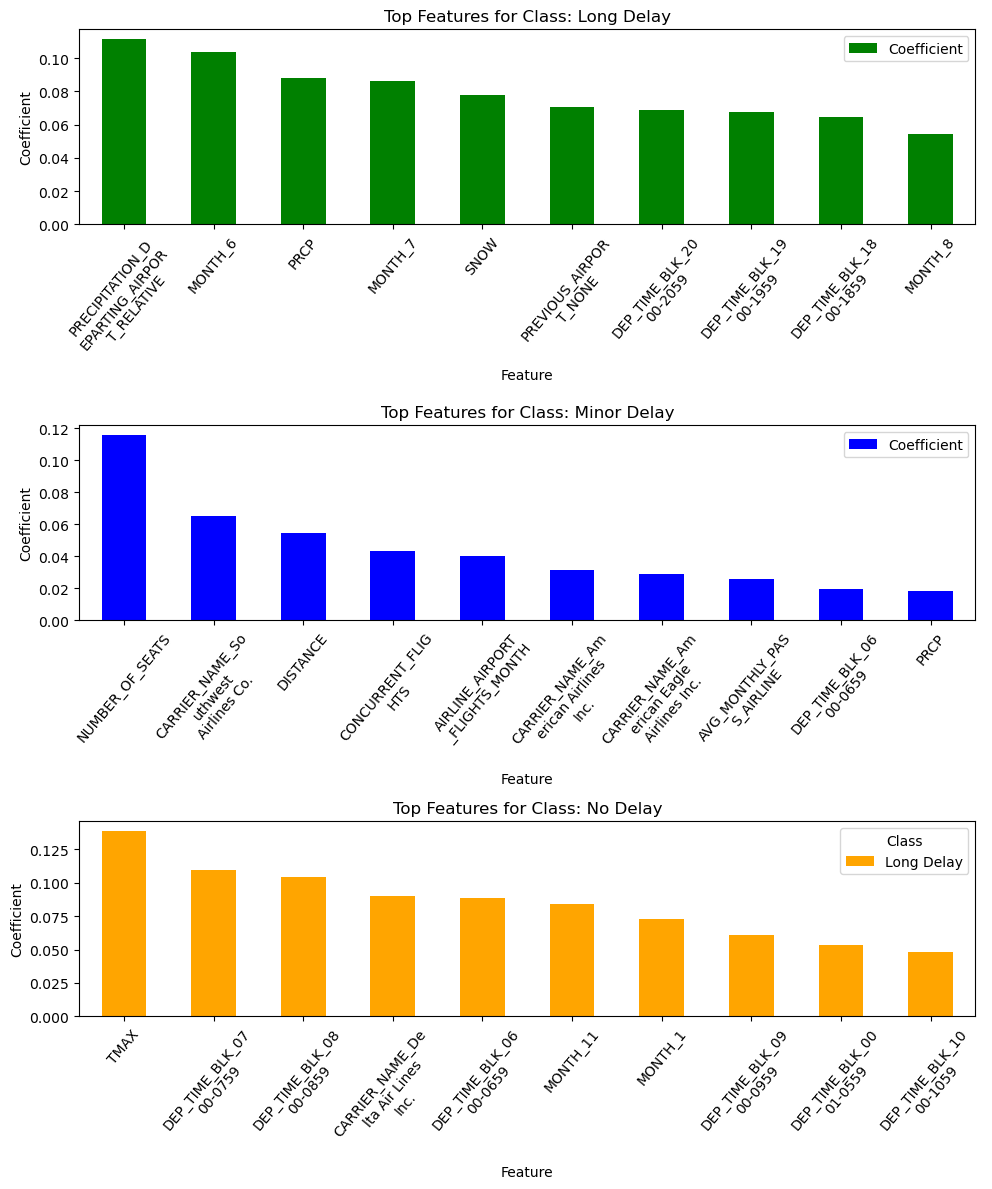

In [55]:
import textwrap

# Get unique class names and assign different colors
class_names = result_df['Class'].unique()
colors = ['green', 'blue', 'orange']

# Create subplots for each class with a smaller figsize
fig, axes = plt.subplots(len(class_names), figsize=(10, 4 * len(class_names)))

# Plot the DataFrame for each class
for i, class_name in enumerate(class_names):
    ax = axes[i]
    class_df = result_df[result_df['Class'] == class_name].copy()  # Make a copy of the DataFrame
    class_df['Wrapped Feature'] = class_df['Feature'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=15)))  # Wrap long column names in the copied DataFrame
    class_df.plot.bar(x='Wrapped Feature', y='Coefficient', ax=ax, color=colors[i % len(colors)])
    ax.set_title(f'Top Features for Class: {class_name}')
    ax.set_xlabel('Feature', fontsize=10)
    ax.set_ylabel('Coefficient')
    ax.tick_params(axis='x', labelrotation=50)  # Rotate x-labels by 50 degrees

# Adjust spacing between subplots
plt.tight_layout()

# Add class names to the legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, class_names, title='Class')

# Display the plot
plt.show()

Above we have a plot of feature weights for each class. For classes Long-Minor-No , the most important features for each are Relative precipitation, number of seats, and maximum temperature. This seems to make logical sense, as heavy rain relative to what the airport is used to can cause takeoff issues, causing a longer delay until the weather clears. More seats means a higher likelyhood of waiting for individuals to arrive and seat on time, causing a slight bump in delay potential. High temperatures mean a lower chance of heavy rain or snow, reducing the chance of weather-related delays.

----

[Index](#top)

----

<a name=2></a>
# Decision Tree Classification

<a name=2a></a>
## Base Modelling

For this model, we will add in cross-validation to see how it can affect the results of a simple base model. In this case, we will split our X_train into 5 sections, 4 of which are for fitting the model and 1 for assessing the model's accuracy. Each of the 5 sections will have a chance to be the assessing chunk; therefore, we will obtain 5 different accuracies and average them for a final result.

In [48]:
# DecisionTreeClassifier with the tested parameters
dt_model = DecisionTreeClassifier(max_depth=3)

# Perform cross-validation and compute the mean accuracy
cv_scores = cross_val_score(dt_model, X_train_scaled, y_train, cv=5)
mean_accuracy = cv_scores.mean()

# Print the cross-validation scores and mean accuracy
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", mean_accuracy)

Cross-Validation Scores: [0.42444395 0.42109852 0.42191809 0.42422952 0.41989051]
Mean Accuracy: 0.4223161170216273


In [50]:
# joblib.dump(gb_classifier, 'dt_model.joblib')

In [49]:
# # Make predictions on the test set
# y_pred = dt_model.predict(X_test)

# # Create the classification report
# report = classification_report(y_test, y_pred)

From a simple cross-validation, we can see how the accuracies vary across splits in the data. This is important as it shows there are trends in different parts of the data that the model is learning from, which isn't actually useful for generalized data tendencies (or at least it's not capturing all of the trends, just parts of them).

<a name=2b></a>
## Hyperparamter Testing

0.440973704825562
0.45525583276531967
0.4598097128181565
0.46312681157400554
0.45996382529248414
0.4518454984463548


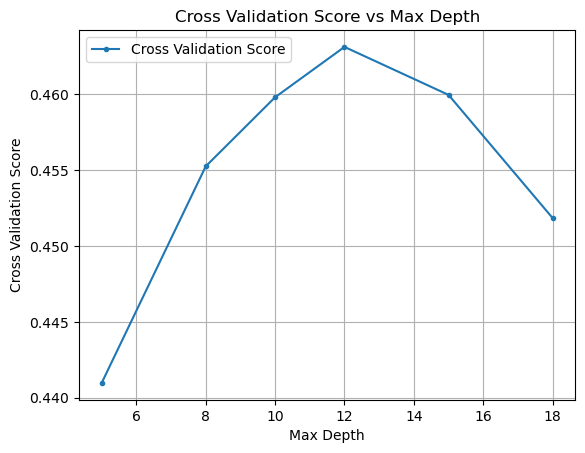

In [56]:
max_depths = [5, 8, 10, 12, 15, 18]
cross_validation_scores = []

# Loop through different max_depth values
for depth in max_depths:
    
    dt_model = DecisionTreeClassifier(max_depth=depth)
    cv_scores = cross_val_score(dt_model, X_train_scaled, y_train, cv=5)
    
    mean_accuracy = cv_scores.mean()
    cross_validation_scores.append(mean_accuracy)
    
    # pring average cross-validation accuracy for each iteration of C
    print(mean_accuracy)

# Plot the cross-validation scores
plt.figure()
plt.plot(max_depths, cross_validation_scores, label="Cross Validation Score", marker='.')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Cross Validation Score')
plt.title('Cross Validation Score vs Max Depth')
plt.grid()
plt.show()

#### Above we see a maximum depth of 12 yields the highest accuracy

0.4598218781038391
0.46282267416989054
0.4630457084909749
0.46343095029363307
0.4620724866230038


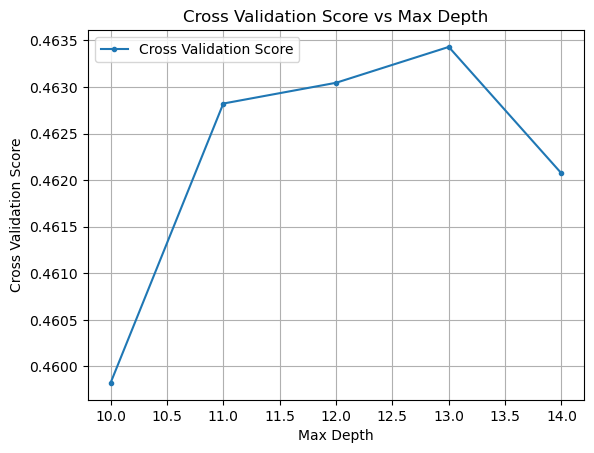

In [57]:
max_depths = [10, 11, 12, 13, 14]
cross_validation_scores = []

# Loop through different max_depth values
for depth in max_depths:
    
    dt_model = DecisionTreeClassifier(max_depth=depth)
    cv_scores = cross_val_score(dt_model, X_train_scaled, y_train, cv=5)
    
    mean_accuracy = cv_scores.mean()
    cross_validation_scores.append(mean_accuracy)
    
    # pring average cross-validation accuracy for each iteration of C
    print(mean_accuracy)

# Plot the cross-validation scores
plt.figure()
plt.plot(max_depths, cross_validation_scores, label="Cross Validation Score", marker='.')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Cross Validation Score')
plt.title('Cross Validation Score vs Max Depth')
plt.grid()
plt.show()

#### Now we see that 13 as max depth supports even higher model accuracy 

We will look at tuning the max feature parameter now below, as well as visualizing percision and recall.

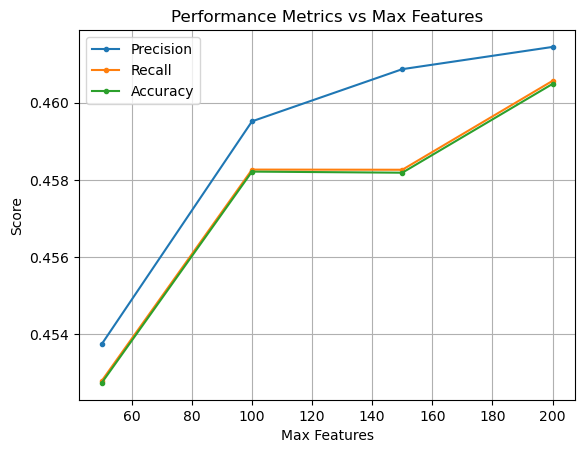

In [65]:
max_features_values = [50, 100, 150, 200, 250]
cross_val_accuracy = []
cross_val_precision = []
cross_val_recall = []

for max_features in max_features_values:
    dt_model = DecisionTreeClassifier(max_depth=11, max_features=max_features)
    
    # Perform cross-validation
    cv_results = cross_validate(dt_model, X_train_scaled, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])
    
    # Get the mean accuracy, precision, and recall across the cross-validation folds
    cross_val_mean_accuracy = np.mean(cv_results['test_accuracy'])
    cross_val_mean_precision = np.mean(cv_results['test_precision_macro'])
    cross_val_mean_recall = np.mean(cv_results['test_recall_macro'])
    
    # Append the cross-validation scores and performance metrics
    cross_val_accuracy.append(cross_val_mean_accuracy)
    cross_val_precision.append(cross_val_mean_precision)
    cross_val_recall.append(cross_val_mean_recall)

# Plot the changes in accuracy over each max_features iteration
plt.figure()
plt.plot(max_features_values, cross_val_accuracy, label="Accuracy", marker='.')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Features')
plt.grid()
plt.show()

# Plot the changes in precision and recall over each max_features iteration
plt.figure()
plt.plot(max_features_values, cross_val_precision, label="Precision", marker='.')
plt.plot(max_features_values, cross_val_recall, label="Recall", marker='.')
plt.xlabel('Max Features')
plt.ylabel('Score')
plt.title('Precision and Recall vs Max Features')
plt.legend()
plt.grid()
plt.show()

The above shows, logically, that as we increase the features (max_features) all of the three scores increase for the validation set. Suggesting more features increases performance.

Next we will look at PCA to see how much varience each feature is potentially providing to the model and target insight.

<a name=2c></a>
## PCA Analysis of Variance

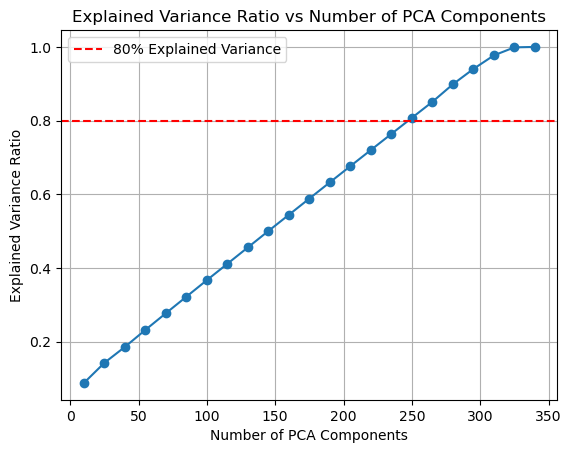

In [18]:
# Define the range of PCA components
n_components_values = range(10, X_train_scaled.shape[1] + 1, 15)
explained_variance_ratios = []

for n_components in n_components_values:
    # Apply PCA to the dataset
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    
    # Get the explained variance ratio
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
    explained_variance_ratios.append(explained_variance_ratio)

plt.figure()
plt.plot(n_components_values, explained_variance_ratios, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of PCA Components')
plt.legend()
plt.grid()
plt.show()

Compared to a more traditional PCA graph, which tends to curve off toward the latter addition of features, we have a very linear increase in explanation. This indicates that the variation across all features is nearly equally important. The effect of adding PCAs in this situation is somewhat suboptimal, as only at around 325 PCA features do we have diminishing returns on adding more PCAs. 

Because PCAs take away some of the interpretability of the features, instead of going from 365 features to 325 PCAs, we will keep all features for the sake of interpretability and maximum feature explanation.

<a name=2d></a>
## Hyperparamerterized Model on Test Set

In [41]:
# DecisionTreeClassifier with the tested parameters
dt_model = DecisionTreeClassifier(max_depth=13)

# Train the model
dt_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = dt_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.46774585975896577


In [45]:
# Visualize the decision tree
graph = Source(export_graphviz(dt_model, out_file=None, feature_names=X.columns))

# Save the decision tree as PDF
output_file_pdf = "decision_tree_final.pdf"
graph.render(output_file_pdf, format='pdf')

# Display the decision tree as SVG
SVG(graph.pipe(format='svg'))


(process:15328): GLib-GIO-WARNING **: 13:40:32.894: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.6.2.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:15180): GLib-GIO-WARNING **: 13:41:02.591: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.6.2.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


In [24]:
# Get the feature importances from the decision tree model
importances = dt_model.feature_importances_

# Get the feature names
feature_names = X.columns

# Create a DataFrame to store the feature importances
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Take the top 20 features
top_20_features = feature_imp_df.head(20)

# Print the top 20 features with their Gini impurity scores
print("Top 20 Features by Gini Impurity:")
top_20_features

Top 20 Features by Gini Impurity:


Feature  Importance
20  PRECIPITATION_DEPARTING_AIRPORT_RELATIVE    0.125289
3                            NUMBER_OF_SEATS    0.118565
1                             SEGMENT_NUMBER    0.063192
0                                   DISTANCE    0.060133
17                                      TMAX    0.055501
2                         CONCURRENT_FLIGHTS    0.047729
18                                      AWND    0.045213
6              AIRLINE_AIRPORT_FLIGHTS_MONTH    0.042187
9                    FLT_ATTENDANTS_PER_PASS    0.033976
11                                 PLANE_AGE    0.029696
5                      AIRLINE_FLIGHTS_MONTH    0.029536
4                      AIRPORT_FLIGHTS_MONTH    0.029299
15                                      SNOW    0.019690
57                    DEP_TIME_BLK_2200-2259    0.018723
14                                      PRCP    0.016284
43                    DEP_TIME_BLK_0800-0859    0.015212
42                    DEP_TIME_BLK_0700-0759    0.013867
41                    DEP_TIME_BLK_0600-0659    0.010619
13                                 LONGITUDE    0.010295
55                    DEP_TIME_BLK_2000-2059    0.008454

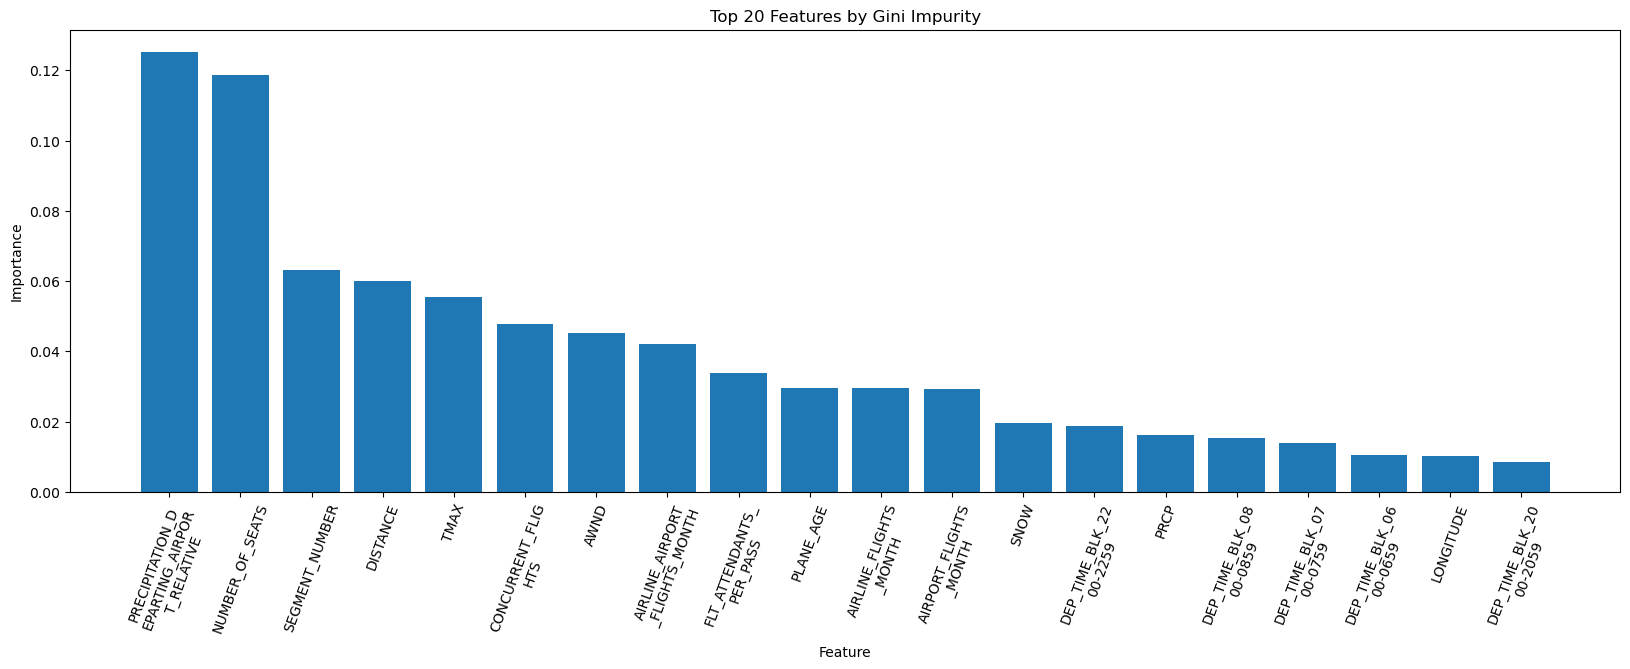

In [35]:
import textwrap

plt.figure(figsize=(20, 6))

# Wrap long words in the feature names to two lines
wrapped_feature_names = [textwrap.fill(feature, 15) for feature in top_20_features['Feature']]

# Plot the top 20 features
plt.bar(wrapped_feature_names, top_20_features['Importance'])

# Set the x-axis labels to be rotated for better readability
plt.xticks(rotation=70)

# Set the labels and title
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 20 Features by Gini Impurity')

# Show the plot
plt.show()

The final model's accuracy increased significantly from 42.2% to 46.8%! Even with one hypperparamter change, we have seen a large increase in accuracy.

For this model, precipitation, number of seats, and maximum temperature are all among the top 5 features of importance for model prediction. Segment number and distance are two important features of this model. Indicating How far the fight will travel and how many stops the airplane has already made are key for splitting the target classes.

-----

[Index](#top)

-----

**Update**

<a name=score></a>
*In the models following, recall for the 'Long Delay' class was included. This is important because the purpose of this analysis is also to more consistently predict long delays, over correctly predicting no delays. 'Long Delay' recall is a measure of how many of the truly late flights we managed to predict out of the true total long delays.*

<a name=3></a>
# Random Forest Classification

<a name=3a></a>
## Base Model - Looking into 'Long Delay' Recall

In [99]:
# Create an instance of the Random Forest classifier with a random state of 30
rf_model = RandomForestClassifier(random_state=30)

# Train the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test_scaled)

# Get the unique class names
class_names = label_encoder.classes_

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix with labels
confusion_mat = confusion_matrix(y_test, y_pred, labels=class_names)
print("Confusion Matrix:")
print(pd.DataFrame(confusion_mat, index=class_names, columns=class_names))



# Calculate recall score using numerical format
recall = recall_score(y_test_numeric, y_pred_numeric, average='weighted')
print("Recall Score:", recall)

Accuracy: 0.48424194254756614
Confusion Matrix:
             Long Delay  Minor Delay  No Delay
Long Delay        10337         5687      4495
Minor Delay        5683         8506      6263
No Delay           3825         5844     11011
Recall Score: 0.4844690272663866


In [131]:
# Calculate recall score specifically for the 'Long Delay' class
recall_long_delay = recall_score(y_test, y_pred, average=None, labels=['Long Delay'])
print("Recall Score for Class 'Long Delay':", recall_long_delay[0])

Recall Score for Class 'Long Delay': 0.5037769871826112


In [110]:
# Get the predicted probabilities for each class
y_pred_prob = rf_model.predict_proba(X_test_scaled)

# Get the class indices for the thresholds
threshold_indices = np.argmax(y_pred_prob, axis=1)

# Get the corresponding thresholds for each class
thresholds = [y_pred_prob[i, idx] for i, idx in enumerate(threshold_indices)]

# Print the class names and their corresponding thresholds
for class_name, threshold in zip(class_names, thresholds):
    print(f"Threshold for Class '{class_name}': {threshold}")

Threshold for Class 'Long Delay': 0.45
Threshold for Class 'Minor Delay': 0.4
Threshold for Class 'No Delay': 0.53


<a name=3b></a>
## Random Forest Hyperparameter Tuning

In [169]:
# Create an instance of the Random Forest classifier with a random state of 30
rf_model = RandomForestClassifier(random_state=30)

# Create a parameter grid to search for the best hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# Create the HalvingGridSearchCV object
halving_cv = HalvingGridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, min_resources="exhaust", factor=3, random_state=30)

# Perform the grid search on the training data
halving_cv.fit(X_train_scaled, y_train_encoded)

# Get the best hyperparameters
best_params = halving_cv.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


As we can see, with some simple testing using HalvingGridSearchCV, the optimal paramters found so far are listed above.
Lets try again with some additional hyperparamters!

In [172]:
# Create an instance of the Random Forest classifier with a random state of 30
rf_model = RandomForestClassifier(random_state=30)

# Create a parameter grid to search for the best hyperparameters
param_grid = {
    'n_estimators': [50, 150, 200],
    'max_depth': [None],
    'min_samples_split': [5, 8],
    'min_samples_leaf': [2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Create the HalvingGridSearchCV object
halving_cv = HalvingGridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, min_resources="exhaust", factor=3, random_state=30)

# Perform the grid search on the training data
halving_cv.fit(X_train_scaled, y_train_encoded)

# Get the best hyperparameters
best_params = halving_cv.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}


Here the 'min_samples_leaf' changes to 3, so we will update this parameter for our next step.

**For comparison, let's see how the hyperparameters work on the test set before we apply thresholding.**

In [25]:
# Create an instance of the Random Forest classifier with the best hyperparameters
rf_model = RandomForestClassifier(
    random_state=30,
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=5
)

# Train the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Get the unique class names
class_names = np.unique(y_train)

# Get the predicted labels
y_pred = rf_model.predict(X_test_scaled)

In [27]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

# Calculate confusion matrix with labels
confusion_mat = confusion_matrix(y_test, y_pred, labels=class_names)
print("Confusion Matrix:")
print(pd.DataFrame(confusion_mat, index=class_names, columns=class_names))
print()

# Calculate recall score specifically for the 'Long Delay' class
recall_long_delay = recall_score(y_test, y_pred, average=None, labels=['Long Delay'])
print("Recall Score for Class 'Long Delay':", recall_long_delay[0])
print()

Accuracy: 0.5017436862338

Confusion Matrix:
             Long Delay  Minor Delay  No Delay
Long Delay        10287         5394      4838
Minor Delay        5307         8859      6286
No Delay           3535         5358     11787

Recall Score for Class 'Long Delay': 0.5013402212583459



The matrix and recall scores above indicate that the new hyperparamters provide a small increase in accuracy compared to the base model, being 0.5017 vs. 0.4842 accuracy.

Though the long Delay' recall of the newly hyperparammeterized model decreased from a score of 0.5038 to 0.5013, This is because we optimized the hyperparameters for accuracy instead of recall initially.

*Below, we will obtain approximate threshold values for our classes. Once obtained, we will see how they affect 'Long Delay' recall scores.*

In [58]:
# Create an instance of the Random Forest classifier with the best hyperparameters
rf_model = RandomForestClassifier(
    random_state=30,
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=5
)

# Perform cross-validation and get the predicted probabilities for each data point
y_pred_prob_cv = cross_val_predict(rf_model, X_train_scaled, y_train, cv=5, method='predict_proba')

In [59]:
# Get the unique class names from the target encoder
class_names = np.unique(y_train)

# Calculate the maximum probability for each class across all cross-validation folds
max_probabilities = y_pred_prob_cv.max(axis=1)

# Create a dictionary to store the average threshold for each class
average_thresholds = {}

# Calculate the average threshold for each class
for i, class_name in enumerate(class_names):
    class_indices = (y_train == class_name)
    average_thresholds[class_name] = max_probabilities[class_indices].mean()

# Print the class names and their average thresholds
for class_name, avg_threshold in average_thresholds.items():
    print(f"Average Threshold for Class '{class_name}': {avg_threshold}")

Average Threshold for Class 'Long Delay': 0.4792605762408894
Average Threshold for Class 'Minor Delay': 0.45728863732587927
Average Threshold for Class 'No Delay': 0.46693325613712844


We will remember the above thresholds for thresholding, where the values for 'Minor Delay' and 'No Delay' stay constant, and test how changing 'Long Delay' thresholds affects the recall score of the 'Long Delay' class.

<a name=3c></a>
## Adjusting Decision Tree Class Thresholds

For the final step in tuning the Decision tree model, we will look at adjusting the 'long Delay' threshold in order to increase the recall of Long Delay predictions while also attempting to maintain accuracy and other class recall scores.

By adjusting the decision threshold, you are essentially changing the cutoff value for classifying each sample into a particular class. This means that you are not changing the model itself or retraining it based on the data. Instead, you are simply making a decision based on the probabilities obtained from the existing model. *This threshold is an addition to the insights the random forest model supplies, adding a layer of manual classification based on the supplied thresholds.*

Therefore, you can directly adjust the decision threshold and calculate accuracy and precision without the need to refit the entire model. This approach is efficient and computationally less expensive than retraining the model for each threshold value. 

Fold 1
Fold 2
Fold 3


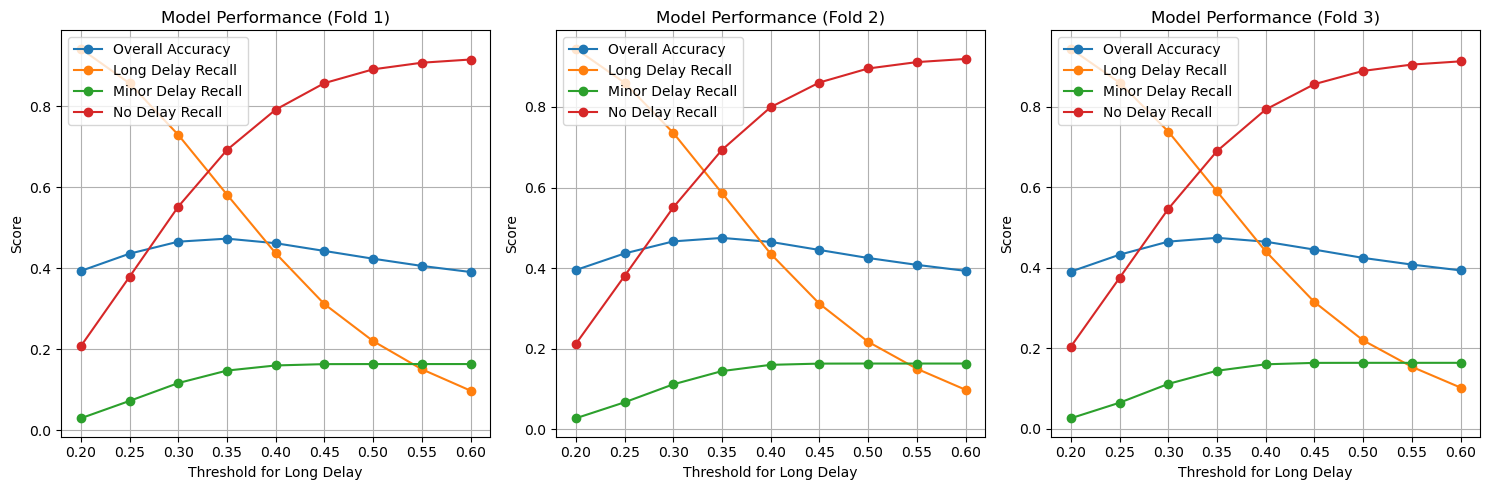

In [68]:
from sklearn.model_selection import KFold

# Convert y_train to a NumPy array
y_train_np = y_train.to_numpy()

# Create a 3-fold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=30)

# Initialize lists to store accuracy and recall results for each threshold and fold
thresholds_long_delay = np.arange(0.2, 0.65, 0.05)  # Adjust the range of thresholds for 'Long Delay'
threshold_minor_delay = 0.4572  # Threshold for 'Minor Delay'
threshold_no_delay = 0.4669  # Threshold for 'No Delay'

# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a list to store the results for each fold
results_list = []

# Loop through each fold in the 3-fold cross-validation
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    print(f"Fold {fold_idx + 1}")
    
    # Split the datdda into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]
    
    # Create an instance of the Random Forest classifier with the best hyperparameters
    rf_model = RandomForestClassifier(
        random_state=30,
        n_estimators=200,
        max_depth=None,
        max_features='sqrt',
        min_samples_leaf=3,
        min_samples_split=5
    )

    # Train the model on the training data for this fold
    rf_model.fit(X_train_fold, y_train_fold)

    # Get the unique class names
    class_names = np.unique(y_train_np)
    
    # Initialize lists to store accuracy and recall results for each threshold for this fold
    accuracies = []
    recall_long_delay_scores = []
    recall_minor_delay_scores = []
    recall_no_delay_scores = []

    # Loop through each threshold value for 'Long Delay' for this fold
    for threshold_long_delay in thresholds_long_delay:
        # Adjust the decision thresholds for each class for this fold
        y_pred_prob = rf_model.predict_proba(X_val_fold)
        y_pred_adjusted_labels = []

        for prob in y_pred_prob:
            if prob[0] >= threshold_long_delay:
                y_pred_adjusted_labels.append(class_names[0])  # Class 'Long Delay'
            elif prob[1] >= threshold_minor_delay and prob[2]:
                y_pred_adjusted_labels.append(class_names[1])  # Class 'Minor Delay'
            else:
                y_pred_adjusted_labels.append(class_names[2])  # Class 'No Delay'

        # Calculate accuracy with adjusted threshold for this fold
        accuracy_adjusted = accuracy_score(y_val_fold, y_pred_adjusted_labels)
        accuracies.append(accuracy_adjusted)

        # Calculate recall scores specifically for each class with adjusted threshold for this fold
        true_labels = label_encoder.transform(y_val_fold)
        predicted_labels = label_encoder.transform(y_pred_adjusted_labels)
        recall_scores = recall_score(true_labels, predicted_labels, average=None)

        # Store recall scores for each class for this fold
        recall_long_delay_scores.append(recall_scores[0])
        recall_minor_delay_scores.append(recall_scores[1])
        recall_no_delay_scores.append(recall_scores[2])
        
        # Update the values for each fold and threshold
        recall_minor_no_delay = recall_scores[1] + recall_scores[2]
        recall_long_delay = recall_scores[0]
        sum_recall = recall_minor_no_delay + recall_long_delay
        
        # Append the results for this threshold and fold to the results_list
        results_list.append({
            'Fold': fold_idx + 1,
            'Threshold': threshold_long_delay,
            'Recall_Long_Delay': recall_long_delay,
            'Sum_Other_Class_Recall': recall_minor_no_delay,
            'Sum_All_Class_Recalls': sum_recall
        })

    # Plot the results for this fold in a subplot
    axes[fold_idx].plot(thresholds_long_delay, accuracies, marker='o', label='Overall Accuracy')
    axes[fold_idx].plot(thresholds_long_delay, recall_long_delay_scores, marker='o', label='Long Delay Recall')
    axes[fold_idx].plot(thresholds_long_delay, recall_minor_delay_scores, marker='o', label='Minor Delay Recall')
    axes[fold_idx].plot(thresholds_long_delay, recall_no_delay_scores, marker='o', label='No Delay Recall')
    axes[fold_idx].set_xlabel('Threshold for Long Delay')
    axes[fold_idx].set_ylabel('Score')
    axes[fold_idx].set_title(f'Model Performance (Fold {fold_idx + 1})')
    axes[fold_idx].legend()
    axes[fold_idx].grid(True)

plt.tight_layout()
plt.show()

In [69]:
# Create a DataFrame from the results_list
results_df = pd.DataFrame(results_list)

# Print the DataFrame containing the results for each fold and threshold
results_df

Fold  Threshold  Recall_Long_Delay  Sum_Other_Class_Recall  \
0      1       0.20           0.941804                0.238128   
1      1       0.25           0.856513                0.452166   
2      1       0.30           0.729415                0.669275   
3      1       0.35           0.582031                0.840039   
4      1       0.40           0.437052                0.952059   
5      1       0.45           0.311737                1.020744   
6      1       0.50           0.220474                1.054916   
7      1       0.55           0.150989                1.071250   
8      1       0.60           0.098183                1.079179   
9      2       0.20           0.944036                0.239996   
10     2       0.25           0.859816                0.447904   
11     2       0.30           0.735508                0.662537   
12     2       0.35           0.586076                0.838191   
13     2       0.40           0.435516                0.959597   
14     2       0.45           0.311717                1.023691   
15     2       0.50           0.217339                1.058603   
16     2       0.55           0.150524                1.074453   
17     2       0.60           0.098347                1.082304   
18     3       0.20           0.944377                0.231298   
19     3       0.25           0.860193                0.440697   
20     3       0.30           0.738841                0.658732   
21     3       0.35           0.590099                0.835010   
22     3       0.40           0.441210                0.954266   
23     3       0.45           0.315281                1.020763   
24     3       0.50           0.220147                1.053774   
25     3       0.55           0.154455                1.069515   
26     3       0.60           0.102860                1.077567   

    Sum_All_Class_Recalls  
0                1.179932  
1                1.308679  
2                1.398690  
3                1.422070  
4                1.389111  
5                1.332481  
6                1.275390  
7                1.222239  
8                1.177362  
9                1.184032  
10               1.307720  
11               1.398045  
12               1.424268  
13               1.395113  
14               1.335408  
15               1.275943  
16               1.224977  
17               1.180651  
18               1.175675  
19               1.300890  
20               1.397572  
21               1.425109  
22               1.395476  
23               1.336044  
24               1.273922  
25               1.223969  
26               1.180427

Above we are experimenting with threholds of classification for 'Long delay'. We are aslo making sure to keep the threshold for class 'Minor Delay' (0.457) and threshold for class 'No Delay': (0.467). Here we can see as our threhold for long delay increases, our recall decreses. 

Ultimately we want a mix of high recall in the important class (long delays) and at the same time have a comparable amount of accuracy and recall in the other classes. At a threhold of 0.350, we can find a good middle ground between total recall, accuracy, and 'Long Delay' recall.

<a name=3d></a>
## Random Forest Test Set Performance

In [19]:
# Create an instance of the Random Forest classifier with the best hyperparameters
rf_model = RandomForestClassifier(
    random_state=30,
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=5
)

# Train the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Get the unique class names
class_names = np.unique(y_train)

# Get the predicted labels on the test set
y_pred = rf_model.predict(X_test_scaled)

# Initialize lists to store accuracy and recall results
threshold_long_delay = 0.350  # Threshold for 'Long Delay'
threshold_minor_delay = 0.457  # Threshold for 'Minor Delay'
threshold_no_delay = 0.467  # Threshold for 'No Delay'

# Initialize a list to store the results
results_list = []

# Adjust the decision thresholds for each class using the specified threshold for 'Long Delay'
y_pred_prob = rf_model.predict_proba(X_test_scaled)
y_pred_adjusted_labels = []

for prob in y_pred_prob:
    if prob[0] >= threshold_long_delay:
        y_pred_adjusted_labels.append(class_names[0])  # Class 'Long Delay'
    elif prob[1] >= threshold_minor_delay and prob[2]:
        y_pred_adjusted_labels.append(class_names[1])  # Class 'Minor Delay'
    else:
        y_pred_adjusted_labels.append(class_names[2])  # Class 'No Delay'

# Calculate accuracy with adjusted threshold
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted_labels)

# Calculate recall scores specifically for each class with adjusted threshold
true_labels = label_encoder.transform(y_test)
predicted_labels = label_encoder.transform(y_pred_adjusted_labels)
recall_scores = recall_score(true_labels, predicted_labels, average=None)

# Calculate the recall for 'Long Delay' class and the sum of recall for other classes
recall_long_delay = recall_scores[0]
recall_minor_no_delay = recall_scores[1] + recall_scores[2]
sum_recall = recall_long_delay + recall_minor_no_delay

# Append the results to the results_list
results_list.append({
    'Threshold': threshold_long_delay,
    'Recall_Long_Delay': recall_long_delay,
    'Sum_Other_Class_Recall': recall_minor_no_delay,
    'Sum_All_Class_Recalls': sum_recall,
    'Accuracy': accuracy_adjusted
})

# Create a DataFrame from the results_list
results_df = pd.DataFrame(results_list)

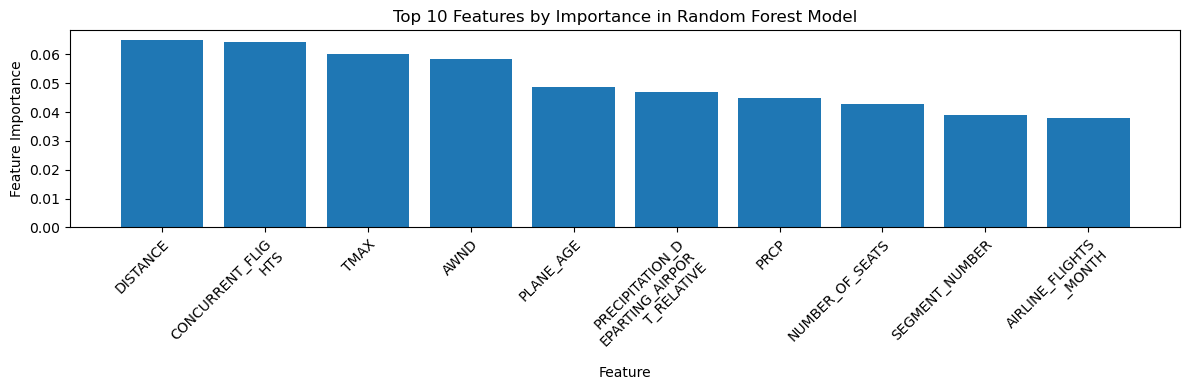

In [68]:
import textwrap

# Get the feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_features = feature_importance_df.head(10)

# Wrap long feature names to a second line
wrapped_feature_names = [textwrap.fill(name, width=15) for name in top_10_features['Feature']]

# Plot the top 10 features vertically
plt.figure(figsize=(12, 4))
plt.bar(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Top 10 Features by Importance in Random Forest Model')
plt.xticks(rotation=45, ha='right')
plt.xticks(range(len(wrapped_feature_names)), wrapped_feature_names, ha='right', rotation_mode='anchor', x=-1)  # Set the wrapped feature names with right alignment and padding
plt.tight_layout()  # Adjust the layout to prevent overlapping of text
plt.show()

In [21]:
results_df

Threshold  Recall_Long_Delay  Sum_Other_Class_Recall  \
0       0.35           0.592768                0.854496   

   Sum_All_Class_Recalls  Accuracy  
0               1.447264  0.483334

Our finalized model shows us that we were able to obtain a good increase in 'Long Delay' recall to 59.28%, while at the same time keeping the accuracy stable! It is to be noted that we lost a bit of accuracy compared to the un-modified threhold model (50.17% accuracy), but we gained more than 9% 'Long Delay' recall. 

Some interesting features for this model not seen in other models are plane age, wind, and concurrent flights (which can thought to be fairly related to segment number).  

Compared to other models tested, we have the highest accurcay so far, 48.33%!

---

[Index](#top)

---

<a name=4></a>
# Support Vector Machines (SVM):

SVM's separate different classes of data points by finding the best possible decision boundary called the "hyperplane" in a high-dimensional space.

Kernelized SVMs require the computation of a distance function between each point in the dataset, which is:

- $O(n_{\text{features}} \times n_{\text{observations}}^2)$ for a linear kernel
- $O(n_{\text{features}} \times n_{\text{observations}}^2 \times n_{\text{support\_vectors}})$ for Radial Basis Function (RBF) kernel.

Therefore, these models are extremely computationally expensive and may take a long time to run. We will import sklearnex which harnesesses Intel processing for increased speeds. 

In [30]:
from sklearnex import patch_sklearn 
patch_sklearn()

from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Let's also check to see how much memory we have to use, SVM's with a large dataset require lost of memory and disk.

In [36]:
import psutil

# Get memory usage statistics
memory_stats = psutil.virtual_memory()

# Print total, available, and used memory in bytes
print("Total Memory:", memory_stats.total)
print("Available Memory:", memory_stats.available)
print("Used Memory:", memory_stats.used)

Total Memory: 17086058496
Available Memory: 8218722304
Used Memory: 8867336192


<a name=4a></a>
## Define Functions for SVM Setup

For the sake of repeatability, we will define three functions that will allow us to streamline the process of building up the SVM models from subsamples and then testing the scores.

In [31]:
def subsample_and_encode(X, y, train_size=0.25, validation_size=0.25):
    # Create a 25% subsample of the training data
    X_train_scaled_subsample, _, y_train_subsample, _ = train_test_split(
        X, y, train_size=train_size, random_state=30
    )

    # Further split the subsampled training data to create a 25% validation subset
    X_train_scaled_subsample, X_val_scaled_subsample, y_train_subsample, y_val_subsample = train_test_split(
        X_train_scaled_subsample, y_train_subsample, train_size=1 - validation_size, random_state=30
    )

    # Create an instance of the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the encoder on the training labels
    label_encoder.fit(y_train_subsample)

    # Transform the training and validation labels
    y_train_encoded = label_encoder.transform(y_train_subsample)
    y_val_encoded = label_encoder.transform(y_val_subsample)

    return X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded

In [32]:
def fit_svm_model(X_train, y_train, X_test_or_val, y_test_or_val, kernel='rbf', C=1, gamma=0.1, cache_size=1800):
    # Create an instance of the SVM classifier with adjusted hyperparameters
    svm_model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        random_state=30,
        probability=True  # Set to False to speed up training
    )

    # Train the SVM model on the scaled training data
    svm_model.fit(X_train, y_train)

    # Get the predicted labels on the test or validation set
    y_pred = svm_model.predict(X_test_or_val)

    return y_pred

Here we are using **RBF** as our kernel, because kernel allows SVM to capture complex and non-linear relationships between features. In our EDA we saw that many of our feature plots were clearly not strongly linear in nature, so RBF kernel can better model these non-linear boundaries.

In [33]:
def evaluate_svm_model(y_test_or_val, y_pred, target_label=0):
    # Calculate accuracy on the test or validation set
    accuracy = accuracy_score(y_test_or_val, y_pred)
    print("Accuracy:", accuracy)
    print()

    # Calculate confusion matrix with labels for test or validation set
    confusion_mat = confusion_matrix(y_test_or_val, y_pred)
    print("Confusion Matrix:")
    print(confusion_mat)
    print()

    # Calculate recall score specifically for the 'Long Delay' class on test or validation set
    recall_target_label = recall_score(y_test_or_val, y_pred, average=None, labels=[target_label])
    print(f"Recall Score for Class '{target_label}':", recall_target_label[0])
    print()

<a name=4b></a>
## Testing SVM with Various Data Sizes and Parameters 

To save time, we will start with a **10% sub sample**. We may expecty this will perform poorly

In [35]:
# Create a 10% subsample of the training data and obtain validation data
X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded = subsample_and_encode(X_train_scaled, y_train, train_size=0.10)

# Time the SVM model fitting
start_time = time.time()
y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='rbf', C=1, gamma=0.1)
end_time = time.time()

# Calculate and print the elapsed time for fitting the SVM model
elapsed_time = (end_time - start_time) / 60  # Convert to minutes
print("Time taken to fit the SVM model:", elapsed_time, "minutes")
print()

# Evaluate the SVM model on the validation set
evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)

Time taken to fit the SVM model: 0.5468666632970174 minutes

Accuracy: 0.3897810218978102

Confusion Matrix:
[[ 793  906  338]
 [ 595 1054  427]
 [ 627  869  556]]

Recall Score for Class '0': 0.38929798723613157



-------

Next, we will increase the **sample size to 40% of the original** X_train data. We want to find a model where the training time isn't too long, but we don't sacrifice too much of the model's accuracy and precision.

In [37]:
# Create a 40% subsample of the training data and obtain validation data
X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded = subsample_and_encode(X_train_scaled, y_train, train_size=0.40)

# Time the SVM model fitting
start_time = time.time()
y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='rbf', C=1, gamma=0.1)
end_time = time.time()

# Calculate and print the elapsed time for fitting the SVM model
elapsed_time = (end_time - start_time) / 60  # Convert to minutes
print("Time taken to fit the SVM model:", elapsed_time, "minutes")
print()

# Evaluate the SVM model on the validation set
evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)

Time taken to fit the SVM model: 8.199387232462565 minutes

Accuracy: 0.41192214111922143

Confusion Matrix:
[[4396 2188 1626]
 [3206 2907 2093]
 [3031 2358 2855]]

Recall Score for Class '0': 0.5354445797807552



Wow, a 4x increase in subsample size took more than 15x longer to fit! We can expect this subsample size-fit ratio to grow further as we increase the sample size. At the same time, we see a huge increase in accuracy and recall! 

**Accuracy:** 0.390 &#8594; 0.412

**Recall:** 0.389 &#8594; 0.535

Lets also compare it to a SVM model trained on a **linear kernal**, using a 40% subsample again

In [38]:
# Create a 40% subsample of the training data and obtain validation data
X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded = subsample_and_encode(X_train_scaled, y_train, train_size=0.40)

# Time the SVM model fitting
start_time = time.time()
y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='linear', C=1, gamma=0.1)
end_time = time.time()

# Calculate and print the elapsed time for fitting the SVM model
elapsed_time = (end_time - start_time) / 60  # Convert to minutes
print("Time taken to fit the SVM model:", elapsed_time, "minutes")
print()

# Evaluate the SVM model on the validation set
evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)

Time taken to fit the SVM model: 14.044549636046092 minutes

Accuracy: 0.4629359286293593

Confusion Matrix:
[[3502 2685 2023]
 [1979 3798 2429]
 [1768 2360 4116]]

Recall Score for Class '0': 0.4265529841656516



Interestingly the accuracy of the linear model is better, but the recall for long delay's are worse. This may mean that long delay trends are less linear in nature, where as the overal combined accuracy is more linear. 

-----------------------------------

Finally, we will gather a **subsample of 60%** of the original data and see how it fits.

*80% of the x_train was tested, and resulted in crashing the system*

In [37]:
# Create a 60% subsample of the training data and obtain validation data
X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded = subsample_and_encode(X_train_scaled, y_train, train_size=0.60)

# Time the SVM model fitting
start_time = time.time()
y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='rbf', C=1, gamma=0.1)
end_time = time.time()

# Calculate and print the elapsed time for fitting the SVM model
elapsed_time = (end_time - start_time) / 60  # Convert to minutes
print("Time taken to fit the SVM model:", elapsed_time, "minutes")
print()

# Evaluate the SVM model on the validation set
evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)

Time taken to fit the SVM model: 20.138536636034647 minutes

Accuracy: 0.42226487523992323

Confusion Matrix:
[[6432 3218 2706]
 [4660 4298 3403]
 [3968 3416 4890]]

Recall Score for Class '0': 0.5205568145030754



Not only is the model now taking quite a bit longer to train, it is also resulting in decreased accuracy and recall scores! This may be due to *overfitting* or *convergence issues*. 

<a name=4c></a>
## SVM Hyperparameter Tuning on Sub-Sampled Data

For the sake of hyperparamter tuning, we will continue to use the 'rbf' kernal, as its quicker to train and it keeps our important score (recall) higher - even though we are sacrificing a seemingly increased accuracy. We will also stick to a 40% sub-sample size.

We will start by testing gamma values, then take a seperate test of C values with that optimal gamma. 

*While it is best practice to test all iterations of gamma and C together (as they will have some form of interaction with oneanother), for the sake of time splitting, and potential crashes, we will assume that taking the best of each parameters isolated, and then combine them, is a good approach.*

---

**Please skim to the bottom of this section to see a summarized dataframe and visual of results**

-----

**C = 10**

In [47]:
# Create a 40% subsample of the training data and obtain validation data
X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded = subsample_and_encode(X_train_scaled, y_train, train_size=0.40)

gammas = [0.1, 0.05, .01]
for gamma in gammas:
    print(f"Testing gamma={gamma}")
    start_time = time.time()
    y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='rbf', C=10, gamma=gamma)
    end_time = time.time()

    elapsed_time = (end_time - start_time) / 60  # Convert to minutes
    print("Time taken to fit the SVM model:", elapsed_time, "minutes")

    # Evaluate the SVM model on the validation set
    evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)
    print()

Testing gamma=0.1
Time taken to fit the SVM model: 10.07701667547226 minutes
Accuracy: 0.4109083536090835

Confusion Matrix:
[[4186 2257 1767]
 [3034 2968 2204]
 [2857 2408 2979]]

Recall Score for Class '0': 0.5098660170523751


Testing gamma=0.05
Time taken to fit the SVM model: 11.603157313664754 minutes
Accuracy: 0.4181265206812652

Confusion Matrix:
[[3712 2413 2085]
 [2628 3127 2451]
 [2316 2456 3472]]

Recall Score for Class '0': 0.4521315468940317


Testing gamma=0.01


C:\Users\three\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken to fit the SVM model: 28.122404368718467 minutes
Accuracy: 0.4211273317112733

Confusion Matrix:
[[3665 2482 2063]
 [2579 3070 2557]
 [2146 2448 3650]]

Recall Score for Class '0': 0.4464068209500609




---

**C = 1**

In [42]:
# Create a 40% subsample of the training data and obtain validation data
X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded = subsample_and_encode(X_train_scaled, y_train, train_size=0.40)

gammas = [0.1, 0.5, 1]
for gamma in gammas:
    print(f"Testing gamma={gamma}")
    start_time = time.time()
    y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='rbf', C=1, gamma=gamma)
    end_time = time.time()

    elapsed_time = (end_time - start_time) / 60  # Convert to minutes
    print("Time taken to fit the SVM model:", elapsed_time, "minutes")

    # Evaluate the SVM model on the validation set
    evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)
    print()

Testing gamma=0.1
Time taken to fit the SVM model: 8.020966164271037 minutes
Accuracy: 0.41192214111922143

Confusion Matrix:
[[4396 2188 1626]
 [3206 2907 2093]
 [3031 2358 2855]]

Recall Score for Class '0': 0.5354445797807552


Testing gamma=0.5
Time taken to fit the SVM model: 8.525711405277253 minutes
Accuracy: 0.344647201946472

Confusion Matrix:
[[ 571 7262  377]
 [ 447 7231  528]
 [ 399 7148  697]]

Recall Score for Class '0': 0.06954933008526187


Testing gamma=1.0
Time taken to fit the SVM model: 8.696462202072144 minutes
Accuracy: 0.3411597729115977

Confusion Matrix:
[[ 444 7487  279]
 [ 335 7460  411]
 [ 313 7422  509]]

Recall Score for Class '0': 0.05408038976857491




In [44]:
gammas = [0.05, 0.01]
for gamma in gammas:
    print(f"Testing gamma={gamma}")
    start_time = time.time()
    y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='rbf', C=1, gamma=gamma)
    end_time = time.time()

    elapsed_time = (end_time - start_time) / 60  # Convert to minutes
    print("Time taken to fit the SVM model:", elapsed_time, "minutes")

    # Evaluate the SVM model on the validation set
    evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)
    print()

Testing gamma=0.05


C:\Users\three\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken to fit the SVM model: 7.85773336092631 minutes
Accuracy: 0.4299675587996756

Confusion Matrix:
[[3792 2390 2028]
 [2613 3156 2437]
 [2258 2331 3655]]

Recall Score for Class '0': 0.46187576126674784


Testing gamma=0.01
Time taken to fit the SVM model: 6.931511346499125 minutes
Accuracy: 0.4500405515004055

Confusion Matrix:
[[3547 2494 2169]
 [2252 3379 2575]
 [1754 2318 4172]]

Recall Score for Class '0': 0.4320341047503045




---

**C = 0.5**

In [45]:
# Create a 40% subsample of the training data and obtain validation data
X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded = subsample_and_encode(X_train_scaled, y_train, train_size=0.40)

gammas = [0.1, 0.5, 1.0]
for gamma in gammas:
    print(f"Testing gamma={gamma}")
    start_time = time.time()
    y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='rbf', C=0.5, gamma=gamma)
    end_time = time.time()

    elapsed_time = (end_time - start_time) / 60  # Convert to minutes
    print("Time taken to fit the SVM model:", elapsed_time, "minutes")

    # Evaluate the SVM model on the validation set
    evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)
    print()

Testing gamma=0.1
Time taken to fit the SVM model: 3.9422216097513836 minutes
Accuracy: 0.3715328467153285

Confusion Matrix:
[[3046 4815  349]
 [2391 5271  544]
 [2213 5186  845]]

Recall Score for Class '0': 0.3710109622411693


Testing gamma=0.5
Time taken to fit the SVM model: 3.9564666628837584 minutes
Accuracy: 0.3359691808596918

Confusion Matrix:
[[ 150 7973   87]
 [ 104 7973  129]
 [  84 7998  162]]

Recall Score for Class '0': 0.018270401948842874


Testing gamma=1.0
Time taken to fit the SVM model: 3.8865227341651916 minutes
Accuracy: 0.3348742903487429

Confusion Matrix:
[[  47 8146   17]
 [  27 8154   25]
 [  26 8161   57]]

Recall Score for Class '0': 0.005724725943970767




---

**C = 0.1**

In [46]:
# Create a 40% subsample of the training data and obtain validation data
X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded = subsample_and_encode(X_train_scaled, y_train, train_size=0.40)

Cs = [0.1, 1, 10]
for C in Cs:
    print(f"Testing gamma={gamma}")
    start_time = time.time()
    y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_val_scaled_subsample, y_val_encoded, kernel='rbf', C=0.1, gamma=gamma)
    end_time = time.time()

    elapsed_time = (end_time - start_time) / 60  # Convert to minutes
    print("Time taken to fit the SVM model:", elapsed_time, "minutes")

    # Evaluate the SVM model on the validation set
    evaluate_svm_model(y_val_encoded, y_pred_svm, target_label=0)
    print()

Testing gamma=1.0
Time taken to fit the SVM model: 3.8870166738828025 minutes
Accuracy: 0.3327656123276561

Confusion Matrix:
[[   0 8210    0]
 [   0 8206    0]
 [   0 8244    0]]

Recall Score for Class '0': 0.0


Testing gamma=1.0
Time taken to fit the SVM model: 3.8940480868021647 minutes
Accuracy: 0.3327656123276561

Confusion Matrix:
[[   0 8210    0]
 [   0 8206    0]
 [   0 8244    0]]

Recall Score for Class '0': 0.0


Testing gamma=1.0
Time taken to fit the SVM model: 3.870700029532115 minutes
Accuracy: 0.3327656123276561

Confusion Matrix:
[[   0 8210    0]
 [   0 8206    0]
 [   0 8244    0]]

Recall Score for Class '0': 0.0




<a name=4d></a>
## SVM Hyperparameter Summary

In [48]:
# Data for the DataFrame
data = {
    'C': [10, 10, 10, 1, 1, 1, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1],
    'gamma': [0.1, 0.05, 0.01, 0.1, 0.5, 1.0, 0.1, 0.5, 1.0, 0.1, 1.0, 1.0],
    'Time (minutes)': [10.08, 11.60, 28.12, 8.02, 8.53, 8.70, 3.94, 3.96, 3.89, 3.89, 3.87, 3.87],
    'Accuracy': [0.41, 0.42, 0.42, 0.41, 0.34, 0.34, 0.37, 0.34, 0.33, 0.33, 0.33, 0.33],
    'Recall (Class 0)': [0.51, 0.45, 0.45, 0.54, 0.07, 0.05, 0.37, 0.02, 0.00, 0.00, 0.00, 0.00]
}

# Create the DataFrame
results_df = pd.DataFrame(data)

# Sort the DataFrame by recall and then by accuracy
results_df = results_df.sort_values(by=['Recall (Class 0)', 'Accuracy'], ascending=[False, False])

# Print the sorted DataFrame
results_df

C  gamma  Time (minutes)  Accuracy  Recall (Class 0)
3    1.0   0.10            8.02      0.41              0.54
0   10.0   0.10           10.08      0.41              0.51
1   10.0   0.05           11.60      0.42              0.45
2   10.0   0.01           28.12      0.42              0.45
6    0.5   0.10            3.94      0.37              0.37
4    1.0   0.50            8.53      0.34              0.07
5    1.0   1.00            8.70      0.34              0.05
7    0.5   0.50            3.96      0.34              0.02
8    0.5   1.00            3.89      0.33              0.00
9    0.1   0.10            3.89      0.33              0.00
10   0.1   1.00            3.87      0.33              0.00
11   0.1   1.00            3.87      0.33              0.00

---

C:\Users\three\AppData\Local\Temp\ipykernel_6208\3425992238.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


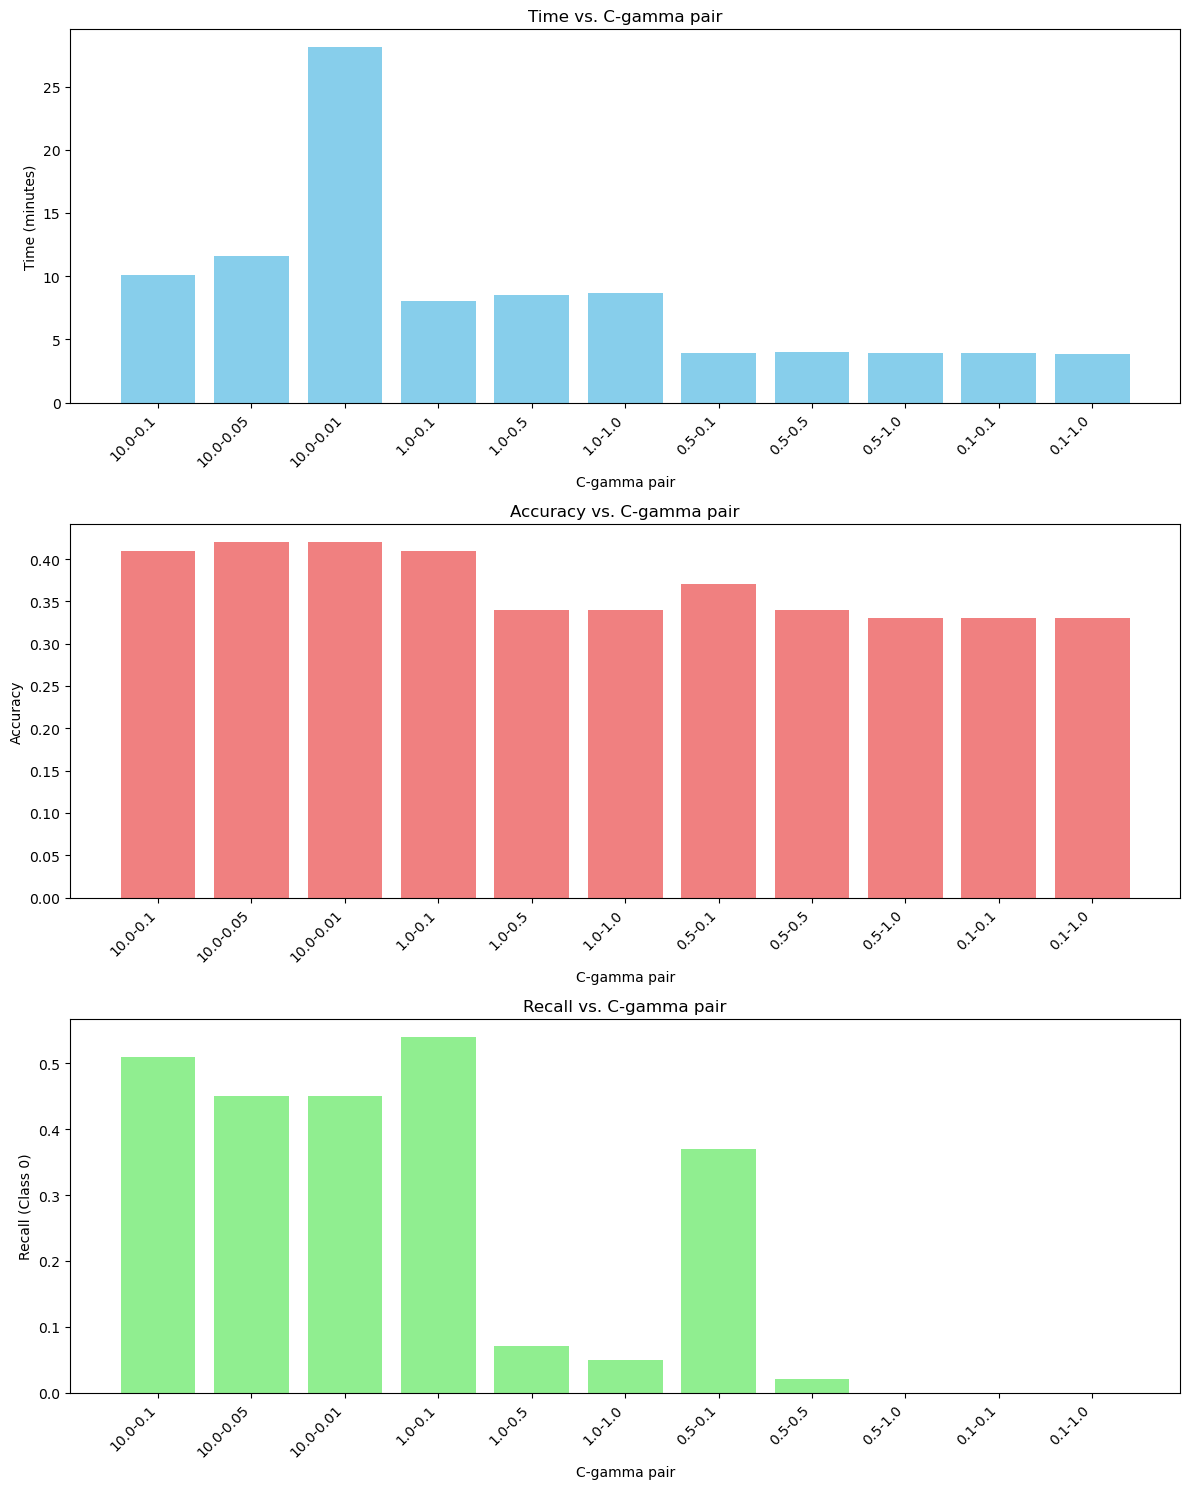

In [59]:
from mpl_toolkits.mplot3d import Axes3D

# Create a new column to hold the C-gamma pair
results_df['C-gamma'] = results_df['C'].astype(str) + '-' + results_df['gamma'].astype(str)

# Set up the subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Subplot 1: Time vs. C-gamma pair
axes[0].bar(results_df['C-gamma'], results_df['Time (minutes)'], color='skyblue')
axes[0].set_xlabel('C-gamma pair')
axes[0].set_ylabel('Time (minutes)')
axes[0].set_title('Time vs. C-gamma pair')

# Subplot 2: Accuracy vs. C-gamma pair
axes[1].bar(results_df['C-gamma'], results_df['Accuracy'], color='lightcoral')
axes[1].set_xlabel('C-gamma pair')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs. C-gamma pair')

# Subplot 3: Recall vs. C-gamma pair
axes[2].bar(results_df['C-gamma'], results_df['Recall (Class 0)'], color='lightgreen')
axes[2].set_xlabel('C-gamma pair')
axes[2].set_ylabel('Recall (Class 0)')
axes[2].set_title('Recall vs. C-gamma pair')

# Rotate x-axis labels for better visibility
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

**C = 10**

Based on the table and plot above, we will take a C value of 1, and a gamma of 0.1. These are the same values as we had in our base models, which we built upon. This combination doesn't have the highest accuracy, but it gives back the highest recall score for the 'Long Delay' class. 

<a name=4e></a>
## SVM Test Data Accuracy

For the last part of the SVM pipeline, we will attempt to fit the model on 60% of the original X_train and then predefine the test set target categories.

In [65]:
# Create a 60% subsample of the training data
X_train_scaled_subsample, _, y_train_subsample, _ = train_test_split(
    X_train_scaled, y_train, train_size=0.60, random_state=30
)

# Create an instance of the LabelEncoder
label_encoder = LabelEncoder()
# Fit the encoder on the training labels
label_encoder.fit(y_train_subsample)
# Transform the training and validation labels
y_train_encoded = label_encoder.transform(y_train_subsample)

# Time the SVM model fitting
start_time = time.time()
y_pred_svm = fit_svm_model(X_train_scaled_subsample, y_train_encoded, X_test_scaled, y_test_encoded, kernel='rbf', C=1, gamma=0.1)
end_time = time.time()

# Calculate and print the elapsed time for fitting the SVM model
elapsed_time = (end_time - start_time) / 60  # Convert to minutes
print("Time taken to fit the SVM model:", elapsed_time, "minutes")
print()

# Evaluate the SVM model on the test set
evaluate_svm_model(y_test_encoded, y_pred_svm, target_label=0)

C:\Users\three\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken to fit the SVM model: 36.23580273389816 minutes

Accuracy: 0.4260920341924705

Confusion Matrix:
[[10498  5597  4424]
 [ 7541  7340  5571]
 [ 6548  5701  8431]]

Recall Score for Class '0': 0.5116233734587455



**Our final accuracy on the test data is 0.4261%, and our recall is 0.5116%**. *This is much worse than the previous Random Forest model.*

Generally, SVMs seem like a good choice for analyzing this fairly non-linear dataset, as the kernel trick does a good job of separating out patterns in the data. But in practice, the hardware limitations and time required to train the model result in suboptimal results.

It's also important to note that the non-linear nature of the SVM 'rbf' model makes feature intereratability much more complicated, as the output support vectors are an amalgamation of non-linear feature weights.

In future testing, a more simple model such as a KNN or a SGD classifier may prove better for the current hardware limitations.

---

[Index](#top)

---

<a name=5></a>
# XGBoost Classification

the final model we will test is xgboost. XGBoost is well-suited for multiclassification tasks due to:

- Its ability to handle complex datasets with multiple classes efficiently. It uses the gradient boosting technique, which builds weak learners (decision trees) to correct errors made by previous trees, resulting in high accuracy.

- It also incorporates L1 and L2 regularization to promote model simplicity and prevent overfitting. 

- The algorithm is also optimized for parallel computing, making it scalable for large multiclass datasets. 

- Most importantly, XGBoost's feature importance analysis helps identify crucial features for each class, providing insights into the model's decision-making process.

<a name=5a></a>
## Baseline XGBoost Modelling

'multi:softmax' will be used for this objective, as this is a multiclass problem. Softmax turns logits into probabilities, which will sum to 1. On the basis of this,it makes a prediction about which classes have the highest probability.

In [79]:
# Create a baseline XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=30
)

# Time the model fitting and predicting
start_time = time.time()
# Fit the model to the training data
xgb_model.fit(X_train_scaled, y_train)
# Make predictions on the test data
y_pred = xgb_model.predict(X_test_scaled)
end_time = time.time()

In [80]:
# Calculate and print the elapsed time for fitting and predicting
elapsed_time = end_time - start_time
print("Time taken for fitting and predicting:", elapsed_time, "seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate and print the recall for the 'Long Delay' class
recall_long_delay = recall_score(y_test, y_pred, average=None)[0]
print("Recall for 'Long Delay' class:", recall_long_delay)

Time taken for fitting and predicting: 149.3470015525818 seconds
Accuracy: 0.4992944153379507
Recall for 'Long Delay' class: 0.49320142307129977


This XGBoost model has given us relativly high accuracy and recall in a short amount of time.
**An accuracy of 49.93% recall of 49.32%**

<a name=5b></a>
## XGBoost Hyperparameter Testing

In [128]:
# 1. Define the parameter grid
param_grid = {
    'max_depth': [6, 7],
    'learning_rate': [0.2, 0.3, 0.4],
    'reg_lambda': [0.1, 0.8, 1],
    'reg_alpha' : [0,1]
}

# 2. Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=30,
)

# 3. Create the HalvingGridSearchCV object
halving_cv = HalvingGridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-8,  # Use all available CPU cores
    factor=3,   # Reduce the search space by a factor of 3 in each iteration
    cv=4,
    min_resources="exhaust",
    random_state=30
)

# 4. Fit the HalvingGridSearchCV object to the training data
start_time = time.time()
halving_cv.fit(X_train, y_train)
end_time = time.time()

# 5. Print the best hyperparameters and the time taken for fitting
print("Best Hyperparameters:", halving_cv.best_params_)
print("Time taken for fitting:", end_time - start_time, "seconds")

# 6. Evaluate the best model on the test data
best_model = halving_cv.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 6, 'reg_alpha': 1, 'reg_lambda': 0.8}
Time taken for fitting: 3458.298534631729 seconds
Accuracy on Test Data: 0.497072229160922


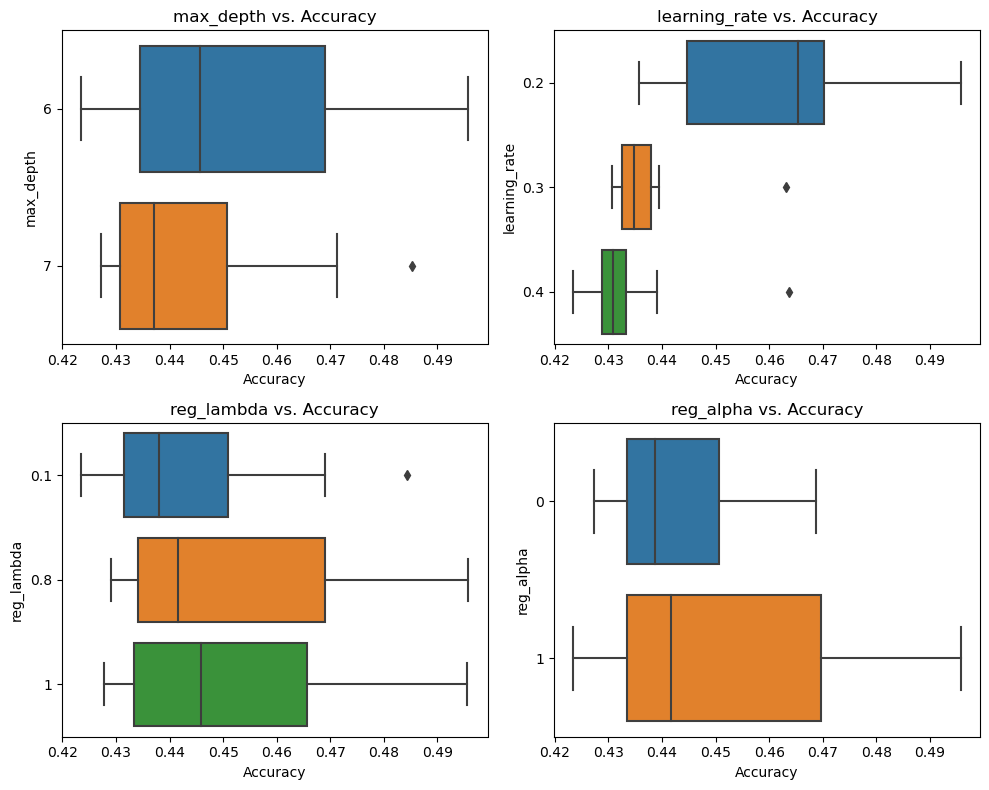

In [139]:
# Create a DataFrame from the results of the HalvingGridSearchCV
results_df = pd.DataFrame(halving_cv.cv_results_)

# Sort the results by mean_test_score (accuracy) in descending order
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Create subplots for each parameter using boxplots in a 2x2 layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.boxplot(data=results_df, y='param_max_depth', x='mean_test_score', orient='h', ax=axes[0, 0])
sns.boxplot(data=results_df, y='param_learning_rate', x='mean_test_score', orient='h', ax=axes[0, 1])
sns.boxplot(data=results_df, y='param_reg_lambda', x='mean_test_score', orient='h', ax=axes[1, 0])
sns.boxplot(data=results_df, y='param_reg_alpha', x='mean_test_score', orient='h', ax=axes[1, 1])

# Set titles and labels for the subplots
axes[0, 0].set_title('max_depth vs. Accuracy')
axes[0, 0].set_ylabel('max_depth')
axes[0, 0].set_xlabel('Accuracy')

axes[0, 1].set_title('learning_rate vs. Accuracy')
axes[0, 1].set_ylabel('learning_rate')
axes[0, 1].set_xlabel('Accuracy')

axes[1, 0].set_title('reg_lambda vs. Accuracy')
axes[1, 0].set_ylabel('reg_lambda')
axes[1, 0].set_xlabel('Accuracy')

axes[1, 1].set_title('reg_alpha vs. Accuracy')
axes[1, 1].set_ylabel('reg_alpha')
axes[1, 1].set_xlabel('Accuracy')

plt.tight_layout()
plt.show()

Now that we have a better idea of what range of parameters may increase accuracy, lets tune the hyperparamters one more time around the highest accuracy hyperparameter ranges.

In [19]:
# 1. Define the parameter grid
param_grid = {
    'max_depth': [5, 6, 7, 8, 10],
    'learning_rate': [0.1, 0.2, 0.3],
    'reg_lambda': [0.7, 0.8, 0.9],
    'reg_alpha' : [1]
}

# 2. Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=30,
)

# 3. Create the HalvingGridSearchCV object
halving_cv = HalvingGridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-8,  # Use all available CPU cores
    factor=3,   # Reduce the search space by a factor of 3 in each iteration
    cv=3,
    min_resources="exhaust",
    random_state=30
)

# 4. Fit the HalvingGridSearchCV object to the training data
start_time = time.time()
halving_cv.fit(X_train, y_train)
end_time = time.time()

# 5. Print the best hyperparameters and the time taken for fitting
print("Best Hyperparameters:", halving_cv.best_params_)
print("Time taken for fitting:", end_time - start_time, "seconds")

# 6. Evaluate the best model on the test data
best_model = halving_cv.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'reg_alpha': 1, 'reg_lambda': 0.9}
Time taken for fitting: 3137.558851957321 seconds
Accuracy on Test Data: 0.4973804155650354


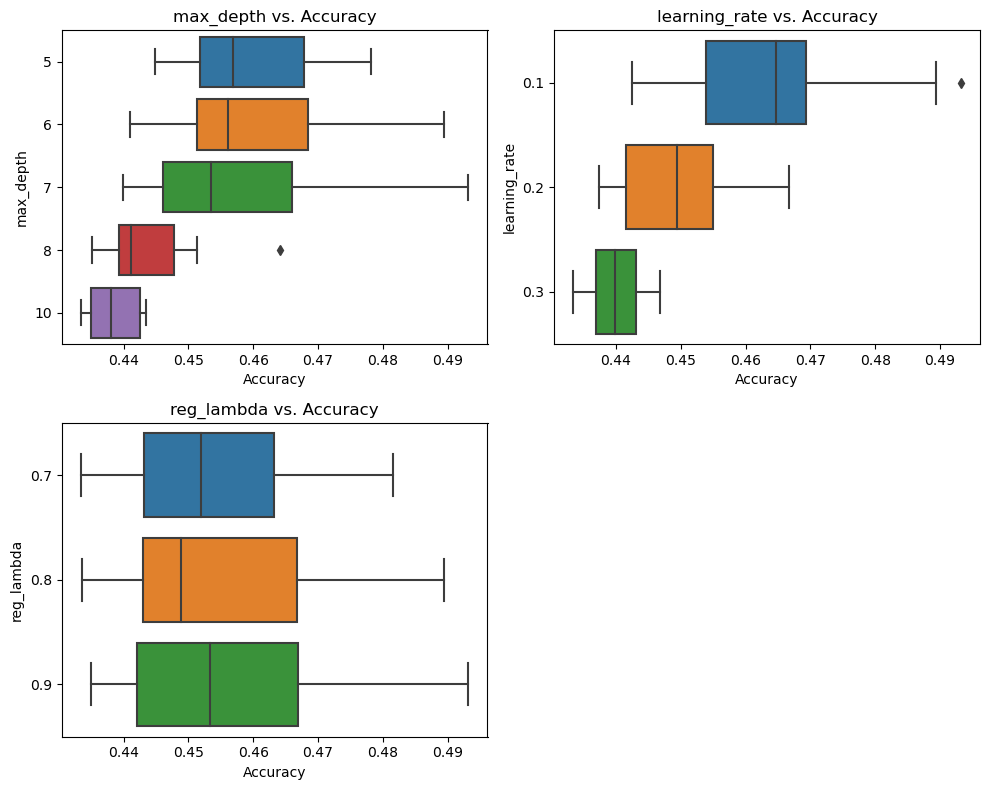

In [20]:
# Create a DataFrame from the results of the HalvingGridSearchCV
results_df = pd.DataFrame(halving_cv.cv_results_)

# Sort the results by mean_test_score (accuracy) in descending order
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Create subplots for each parameter using boxplots in a 2x2 layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.boxplot(data=results_df, y='param_max_depth', x='mean_test_score', orient='h', ax=axes[0, 0])
sns.boxplot(data=results_df, y='param_learning_rate', x='mean_test_score', orient='h', ax=axes[0, 1])
sns.boxplot(data=results_df, y='param_reg_lambda', x='mean_test_score', orient='h', ax=axes[1, 0])

# Remove the empty subplot at (1, 1)
axes[1, 1].remove()

# Set titles and labels for the subplots
axes[0, 0].set_title('max_depth vs. Accuracy')
axes[0, 0].set_ylabel('max_depth')
axes[0, 0].set_xlabel('Accuracy')

axes[0, 1].set_title('learning_rate vs. Accuracy')
axes[0, 1].set_ylabel('learning_rate')
axes[0, 1].set_xlabel('Accuracy')

axes[1, 0].set_title('reg_lambda vs. Accuracy')
axes[1, 0].set_ylabel('reg_lambda')
axes[1, 0].set_xlabel('Accuracy')

plt.tight_layout()
plt.show()

now we have our optimal hyperparameters. What is important to note, is that within one given value of a paramter, we see extreme ranges of accuracy scores. For example, a max_depth of 7 has scores ranging from 44%-49% accuracy! This indicates that there may be some performance issues due to the following reasons: 

- The hyperparameterized model might be overfitting to the training data. 
</br>

- The data is noisy, resulting in it negatively impacting the model's performance, especially if the hyperparameterized model is sensitive to the nosy patterns. A more complex model such as XGBoost can capture noise and random patterns in the data, leading to worse performance compared to a simpler model that generalizes better.

<a name=5c></a>
## XGBoost Test Set Accuracy

In [70]:
# Best Hyperparameters
best_hyperparameters = {'learning_rate': 0.1, 'max_depth': 7, 'reg_alpha': 1, 'reg_lambda': 0.9}

# Create a baseline XGBoost model with the best hyperparameters
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=30,
    learning_rate=best_hyperparameters['learning_rate'],
    max_depth=best_hyperparameters['max_depth'],
    reg_lambda=best_hyperparameters['reg_lambda'],
    reg_alpha=best_hyperparameters['reg_alpha']
)

# Time the model fitting and predicting
start_time = time.time()
# Fit the model to the training data
xgb_model.fit(X_train_scaled, y_train)
# Make predictions on the test data
y_pred = xgb_model.predict(X_test_scaled)
end_time = time.time()

In [71]:
# Calculate and print the elapsed time for fitting and predicting
elapsed_time = end_time - start_time
print("Time taken for fitting and predicting:", elapsed_time, "seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate and print the recall for the 'Long Delay' class
recall_long_delay = recall_score(y_test, y_pred, average=None)[0]
print("Recall for 'Long Delay' class:", recall_long_delay)

Time taken for fitting and predicting: 193.30734205245972 seconds
Accuracy: 0.49739663590209404
Recall for 'Long Delay' class: 0.48199229981967934


With an accuracy of 49.74%, we've ended up with a lower accuracy score than our base model! As discussed above, the hyperparameter tuning gave us a wide range of accuracy scores. This further indicates that the data may be noisy or the hyperparametes may be overfitting, even though we have attempted to regularize them.

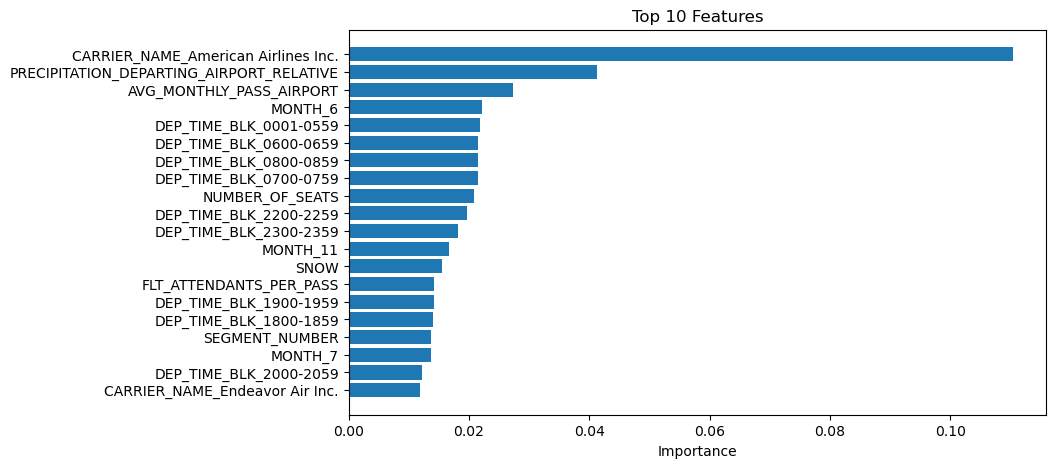

In [29]:
# Get feature importances from the XGBoost model
importances = xgb_model.feature_importances_

# Get the indices of the top 10 features
top_10_indices = importances.argsort()[-20:]

# Get the names of the top 10 features
top_10_features = X_train.columns[top_10_indices]

# Get the importance values of the top 10 features
top_10_importances = importances[top_10_indices]

# Plot the top 10 features and their importances
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(range(len(top_10_features)), top_10_importances, align='center')
ax.set_yticks(range(len(top_10_features)))
ax.set_yticklabels(top_10_features)
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features')
plt.show()

Finally, we can see how XGBoost has ranked its features importance. Interestingly, there are two new top features in the top 3 compared to the Logistic and Decision tree models. First top feature, is the plane being American Airlines. It suggests that there is a pattern to be picked up within that airline, which further analysis could be done on. The second is precipitation, as seen in models before. Third is the average monthly passenger count at the airport, again suggesting there may be certain thresholds of passengers at the airport that produce a discernible pattern.

-----

<a name=6></a>
# Modeling Analysis

A point-form summary from each modeling phase is outlined below:

### Logistic Regression:

- Base accuracy: 46.58%.
- Best hyperparameters: 'solver'='saga', 'C'=1, accuracy: 46.59%.
- Feature analysis: Important features for each class are Relative precipitation, number of seats, and maximum temperature.
- Final hyperparameterized model: Accuracy remained at 46.58% with no improvement over the base model.


### Decision Tree Classification:

- Cross-validation: Mean accuracy was 42.23%.
- Feature analysis: Variation across all features is nearly equally important, keeping all features for interpretability.
- Final model: Accuracy increased significantly to 46.80% with hyperparameter tuning.


### Random Forest Classification:

- Base accuracy: 48.42%, Recall for 'Long Delay': 50.38%.
- Hyperparameter tuning: Achieved 48.33% accuracy and 59.28% 'Long Delay' recall, the highest accuracy so far.
- Adjusting threshold: A good balance between total recall, accuracy, and 'Long Delay' recall was found at a threshold of 0.350.


### Support Vector Machines (SVM):

- RBF kernel used to capture complex non-linear relationships.
- SVM on 40% subsample: Accuracy increased to 41.2%, and 'Long Delay' recall to 53.5%.
- Final model on 60% subsample: Accuracy of 42.61% and 'Long Delay' recall of 51.16% achieved.
- SVM's non-linear nature made feature interpretability more complicated, and hardware limitations impacted performance.


### XGBoost Classification:

- 'multi:softmax' used for multiclass problem with an accuracy of 49.93% and recall of 49.32%.
- Hyperparameter tuning: Accuracy ranged from 44% to 49.74%, indicating potential overfitting or noise in data.
- Important features: American Airlines, precipitation, and average monthly passenger count at the airport.

In [27]:
data = {
    'Base Accuracy': [46.58, 42.23, 48.42, 42.61, 49.93],
    'Final Accuracy': [46.58, 46.77, 48.33, 42.61, 49.74],
    'Base Recall (Long Delay)': [float('nan'), float('nan'), 50.38, 51.16, 49.32],
    'Final Recall (Long Delay)': [float('nan'), float('nan'), 59.28, 51.16, 48.20]
}

index = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'XGBoost']

df = pd.DataFrame(data, index=index)
df.index.name = 'Model'

# Format the numbers with percentage
df = df.applymap(lambda x: f"{x:.2f}%" if not pd.isnull(x) else 'N/A')
df

Base Accuracy Final Accuracy Base Recall (Long Delay)  \
Model                                                                       
Logistic Regression        46.58%         46.58%                      N/A   
Decision Tree              42.23%         46.77%                      N/A   
Random Forest              48.42%         48.33%                   50.38%   
SVM                        42.61%         42.61%                   51.16%   
XGBoost                    49.93%         49.74%                   49.32%   

                    Final Recall (Long Delay)  
Model                                          
Logistic Regression                       N/A  
Decision Tree                             N/A  
Random Forest                          59.28%  
SVM                                    51.16%  
XGBoost                                48.20%

<a name=7></a>
# Conclusion and Future Modeling Direction

In the flight delay modeling, we experimented with various classification models to predict flight delays based on different features. Logistic Regression and Decision Tree models were used as initial explorations, while Random Forest, SVM, and XGBoost were explored for more complexity and better performance.

The Random Forest model proved to be the most effective, achieving an accuracy of 48.33% and a significant recall of 59.28% for the 'Long Delay' class after threshold adjustment. It balanced the trade-offs between total recall, accuracy, and recall for important classes.

SVM, though theoretically promising for non-linear datasets, faced limitations due to computational expenses and data noise. Future SVM Analysis should be done in a cloud setting. XGBoost showed competitive performance but exhibited sensitivity to hyperparameter tuning, indicating potential overfitting or noisy patterns in the data.

For future modeling, noise in the data should be further explored as a way to improve the interpretability of complex models like SVM and XGBoost. Additionally, further analysis of airline-specific patterns and passenger counts at airports could provide valuable insights for predicting flight delays more accurately.

[Index](#top)